## Import functions

In [12]:
import MDAnalysis as mda
#from MDAnalysis.tests.datafiles import PSF, DCD, CRD, DCD2, PDB_small
from MDAnalysis.analysis import distances,diffusionmap, align, rms,contacts,dihedrals, encore
from MDAnalysis.analysis.rms import RMSF
import MDAnalysis.analysis.pca as pca
#import mdtraj as md
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patch
import matplotlib.ticker as ticker
import matplotlib.animation as animation
from mpl_toolkits.axisartist.parasite_axes import SubplotHost
import matplotlib.pylab as pylab
import matplotlib.patches as mpatches
from itertools import product
import timeit
import time
import math
import os.path
import seaborn as sns
import pandas as pd
import csv
import sklearn
import scipy as sp
from scipy.stats import entropy
#from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.spatial import Voronoi,voronoi_plot_2d
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
#from sklearn.decomposition import PCA
import csv
from matplotlib.colors import to_rgb
from matplotlib.collections import PolyCollection
from matplotlib.legend_handler import HandlerTuple
import scipy.signal as sig
from scipy.stats import gaussian_kde
from scipy.spatial import ConvexHull, convex_hull_plot_2d

import glob

## Set Paths

In [13]:
project_path = '/Users/javingfun/Library/CloudStorage/OneDrive-UCSanDiego/UCSD_PhD/Projects/Mpro_MD_dry'

#apo path
apo_path = os.path.join(project_path,'mpro_apo')

apo_monomer_path = os.path.join(apo_path,'mpro_apo_monomer')
apo_dimer_path = os.path.join(apo_path,'mpro_apo_dimer')

#ens_path
ens_path = os.path.join(project_path,'mpro_ens')

ens_monomer_path = os.path.join(ens_path,'mpro_ens_monomer')
ens_dimer_path = os.path.join(ens_path,'mpro_ens_dimer')
ens_dimer_asym_path = os.path.join(ens_path,'mpro_ens_dimer_asym')

#nirm_path
nirm_path = os.path.join(project_path,'mpro_nirm')

nirm_monomer_path = os.path.join(nirm_path,'mpro_nirm_monomer')
nirm_dimer_path = os.path.join(nirm_path,'mpro_nirm_dimer')
nirm_dimer_asym_path = os.path.join(nirm_path,'mpro_nirm_dimer_asym')

#nat_path
nat_path = os.path.join(project_path,'mpro_nat')

nat_monomer_path = os.path.join(nat_path,'mpro_nat_monomer')
nat_dimer_path = os.path.join(nat_path,'mpro_nat_dimer')
nat_dimer_asym_path = os.path.join(nat_path,'mpro_nat_dimer_asym')

## Define Functions

In [14]:
def make_universe(path,replica):
    
    #obtain trajectory and topology from file, create a universe
    if replica == 0:
        topology = glob.glob(os.path.join(path,'*.pdb'))
        u = mda.Universe(topology[0])
        
    
    else:
        topology = glob.glob(os.path.join(path,'*.prmtop'))
        trajectory = glob.glob(os.path.join(path, '*{rep}.nc'.format(rep=replica))) 
        u = mda.Universe(topology[0], trajectory[0])
        
    return u

In [15]:
def combine_universe(path):
    #obtain trajectory and topology from file, create a universe

    topology = glob.glob(os.path.join(path,'*.prmtop'))
    trajectory = glob.glob(os.path.join(path, '*.nc')) 

    u = mda.Universe(topology[0], trajectory[0], trajectory[1], trajectory[2])
        
    return u

In [16]:
def calc_pca(u,sel_dict):
    
    #create dictionary to store pca results per selection
    pca_dict = {}
    
    #iterate over selecitons and calculate pca for each iteraction, appending to dictionary
    for key,value in sel_dict.items():
        selection = value
        print(key,value)
        PSF_pca=pca.PCA(u, select=selection)
        PSF_pca.run()
        n_pcs = np.where(PSF_pca.cumulated_variance > 0.95)[0][0]
        atomgroup = u.select_atoms(selection)
        pca_space = PSF_pca.transform(atomgroup, n_components=n_pcs)
        
        pca_dict[key] = pca_space
        
    return(pca_dict)

In [17]:
def plot_pca(monomer,a,b,sel):
    monomer = monomer[sel]
    a = a[sel] 
    b = b[sel]
    
    fig, axs = plt.subplots(1,4, sharex=True, sharey=True, tight_layout=True, figsize=(24,8))
    fig.add_subplot(111, frameon=False)

    axs[0].scatter(monomer[:,0],monomer[:,1],color='black',label='Monomer')
    axs[0].scatter(b[:,0],b[:,1],color='gray',label='Chain B')
    axs[0].scatter(a[:,0],a[:,1],color='silver',label='Chain A')
    axs[0].set_title("All")

    axs[1].scatter(a[:,0],a[:,1],color='silver',label='Chain A')
    axs[1].set_title("Dimer A")

    axs[2].scatter(b[:,0],b[:,1],color='gray',label='Chain B')
    axs[2].set_title("Dimer B")

    axs[3].scatter(monomer[:,0],monomer[:,1],color='black',label='Monomer')
    axs[3].set_title("Monomer")



    plt.xlabel('PCA1')
    plt.ylabel('PCA2')
    plt.legend()
    #plt.title('Apo Dimer PCA: Full Protomer')

## Define Systems

In [18]:
#apo 
am_0 = make_universe(apo_monomer_path,0)
am_1 = make_universe(apo_monomer_path,1)
am_2 = make_universe(apo_monomer_path,2)
am_3 = make_universe(apo_monomer_path,3)
am_4 = combine_universe(apo_monomer_path)

ad_0 = make_universe(apo_dimer_path,0)
ad_1 = make_universe(apo_dimer_path,1)
ad_2 = make_universe(apo_dimer_path,2)
ad_3 = make_universe(apo_dimer_path,3)
ad_4 = combine_universe(apo_dimer_path)

am_list = [am_1,am_2,am_3]
ad_list = [ad_1,ad_2,ad_3]

#ens 
em_0 = make_universe(ens_monomer_path,0)
em_1 = make_universe(ens_monomer_path,1)
em_2 = make_universe(ens_monomer_path,2)
em_3 = make_universe(ens_monomer_path,3)
em_4 = combine_universe(ens_monomer_path)

ed_0 = make_universe(ens_dimer_path,0)
ed_1 = make_universe(ens_dimer_path,1)
ed_2 = make_universe(ens_dimer_path,2)
ed_3 = make_universe(ens_dimer_path,3)
ed_4 = combine_universe(ens_dimer_path)

ea_0 = make_universe(ens_dimer_asym_path,0)
ea_1 = make_universe(ens_dimer_asym_path,1)
ea_2 = make_universe(ens_dimer_asym_path,2)
ea_3 = make_universe(ens_dimer_asym_path,3)
ea_4 = combine_universe(ens_dimer_asym_path)

em_list = [em_1,em_2,em_3]
ed_list = [ed_1,ed_2,ed_3]
ea_list = [ea_1,ea_2,ea_3]

#nirm monomer
nm_0 = make_universe(nirm_monomer_path,0)
nm_1 = make_universe(nirm_monomer_path,1)
nm_2 = make_universe(nirm_monomer_path,2)
nm_3 = make_universe(nirm_monomer_path,3)
nm_4 = combine_universe(nirm_monomer_path)

nd_0 = make_universe(nirm_dimer_path,0)
nd_1 = make_universe(nirm_dimer_path,1)
nd_2 = make_universe(nirm_dimer_path,2)
nd_3 = make_universe(nirm_dimer_path,3)
nd_4 = combine_universe(nirm_dimer_path)

#asymmetric dimer has ligand on B
na_0 = make_universe(nirm_dimer_asym_path,0)
na_1 = make_universe(nirm_dimer_asym_path,1)
na_2 = make_universe(nirm_dimer_asym_path,2)
na_3 = make_universe(nirm_dimer_asym_path,3)
na_4 = combine_universe(nirm_dimer_asym_path)

nm_list = [nm_1,nm_2,nm_3]
nd_list = [nd_1,nd_2,nd_3]
na_list = [na_1,na_2,na_3]

#nat monomer
pm_0 = make_universe(nat_monomer_path,0)
pm_1 = make_universe(nat_monomer_path,1)
pm_2 = make_universe(nat_monomer_path,2)
pm_3 = make_universe(nat_monomer_path,3)
pm_4 = combine_universe(nat_monomer_path)

pd_0 = make_universe(nat_dimer_path,0)
pd_1 = make_universe(nat_dimer_path,1)
pd_2 = make_universe(nat_dimer_path,2)
pd_3 = make_universe(nat_dimer_path,3)
pd_4 = combine_universe(nat_dimer_path)

pa_0 = make_universe(nat_dimer_asym_path,0)
pa_1 = make_universe(nat_dimer_asym_path,1)
pa_2 = make_universe(nat_dimer_asym_path,2)
pa_3 = make_universe(nat_dimer_asym_path,3)
pa_4 = combine_universe(nat_dimer_asym_path)

pm_list = [pm_1,pm_2,pm_3]
pd_list = [pd_1,pd_2,pd_3]
pa_list = [pa_1,pa_2,pa_3]

## Create selections

In [57]:
selection_a = {'protomer':'protein and resid 1-306 and name CA', #protomer
               'domain1':'protein and resid 1-101 and name CA', #domain I
               'domain2':'protein and resid 102-184 and name CA', #domain II
               'idl':'protein and resid 185-200 and name CA', #IDL loop
               'domain3':'protein and resid 201-306 and name CA', #domain III
               'interface_ss':'protein and resid 1-14 109-172 290-306 and name CA',
               'nterm':'protein and resid 1-10 and name CA',
              'cterm':'protein and resid 295-306 and name CA'} #interface SS

selection_b = {'protomer':'protein and resid 307-612 and name CA', #protomer
               'domain1':'protein and resid 307-407 and name CA', #domain I
               'domain2':'protein and resid 408-490 and name CA', #domain II
               'idl':'protein and resid 491-506 and name CA', #IDL loop
               'domain3':'protein and resid 507-612 and name CA', #domain III
               'interface_ss':'protein and resid 307-320 415-478 596-612 and name CA',
               'nterm':'protein and resid 307-314 and name CA',
              'cterm':'protein and resid 600-612 and name CA'} #interface SS


def make_range_selection(start,stop,protomer): 
    
    def get_b(a):
        return a + 306
    
    if protomer == 'a':
        return f"protein and resid {start}-{stop} and name CA"
        
    elif protomer == 'b':
        return f"protein and resid {get_b(start)}-{get_b(stop)} and name CA"


sel_dict = {'protomer':[1,306],
            'domain1':[1,101],'domain2':[102,184],
            'idl':[185,200],'domain3':[201,306],
           'interface_ss':[1,14,109,172,290,306]}

for key,value in sel_dict.items():
    if len(value) == 2:
        start = value[0]
        stop = value[1]
        sel_b = make_range_selection(start,stop,'b')
        print(value)
    else:
        pass

[1, 306]
[1, 101]
[102, 184]
[185, 200]
[201, 306]


## Calculate PCA

### Apo

In [58]:
#Monomer
apo_monomer_pca = calc_pca(am_4,selection_a)

#Dimer
apo_dimer_a_pca = calc_pca(ad_4,selection_a)
apo_dimer_b_pca = calc_pca(ad_4,selection_b)

protomer protein and resid 1-306 and name CA
domain1 protein and resid 1-101 and name CA
domain2 protein and resid 102-184 and name CA
idl protein and resid 185-200 and name CA
domain3 protein and resid 201-306 and name CA
interface_ss protein and resid 1-14 109-172 290-306 and name CA
nterm protein and resid 1-10 and name CA
cterm protein and resid 295-306 and name CA
protomer protein and resid 1-306 and name CA
domain1 protein and resid 1-101 and name CA
domain2 protein and resid 102-184 and name CA
idl protein and resid 185-200 and name CA
domain3 protein and resid 201-306 and name CA
interface_ss protein and resid 1-14 109-172 290-306 and name CA
nterm protein and resid 1-10 and name CA
cterm protein and resid 295-306 and name CA
protomer protein and resid 307-612 and name CA
domain1 protein and resid 307-407 and name CA
domain2 protein and resid 408-490 and name CA
idl protein and resid 491-506 and name CA
domain3 protein and resid 507-612 and name CA
interface_ss protein and resi

### Peptide

In [59]:
#Monomer
nat_monomer_pca = calc_pca(pm_4,selection_a)

#Asymmetric
nat_asym_a_pca = calc_pca(pa_4,selection_a)
nat_asym_b_pca = calc_pca(pa_4,selection_b)

#Fully bound
nat_dimer_a_pca = calc_pca(pd_4,selection_a)
nat_dimer_b_pca = calc_pca(pd_4,selection_b)

protomer protein and resid 1-306 and name CA
domain1 protein and resid 1-101 and name CA
domain2 protein and resid 102-184 and name CA
idl protein and resid 185-200 and name CA
domain3 protein and resid 201-306 and name CA
interface_ss protein and resid 1-14 109-172 290-306 and name CA
nterm protein and resid 1-10 and name CA
cterm protein and resid 295-306 and name CA
protomer protein and resid 1-306 and name CA
domain1 protein and resid 1-101 and name CA
domain2 protein and resid 102-184 and name CA
idl protein and resid 185-200 and name CA
domain3 protein and resid 201-306 and name CA
interface_ss protein and resid 1-14 109-172 290-306 and name CA
nterm protein and resid 1-10 and name CA
cterm protein and resid 295-306 and name CA
protomer protein and resid 307-612 and name CA
domain1 protein and resid 307-407 and name CA
domain2 protein and resid 408-490 and name CA
idl protein and resid 491-506 and name CA
domain3 protein and resid 507-612 and name CA
interface_ss protein and resi

### Nirmatrelvir

In [60]:
#Monomer
nirm_monomer_pca = calc_pca(nm_4,selection_a)

#Asymmetric
nirm_asym_a_pca = calc_pca(na_4,selection_a)
nirm_asym_b_pca = calc_pca(na_4,selection_b)

#Fully bound
nirm_dimer_a_pca = calc_pca(nd_4,selection_a)
nirm_dimer_b_pca = calc_pca(nd_4,selection_b)

protomer protein and resid 1-306 and name CA
domain1 protein and resid 1-101 and name CA
domain2 protein and resid 102-184 and name CA
idl protein and resid 185-200 and name CA
domain3 protein and resid 201-306 and name CA
interface_ss protein and resid 1-14 109-172 290-306 and name CA
nterm protein and resid 1-10 and name CA
cterm protein and resid 295-306 and name CA
protomer protein and resid 1-306 and name CA
domain1 protein and resid 1-101 and name CA
domain2 protein and resid 102-184 and name CA
idl protein and resid 185-200 and name CA
domain3 protein and resid 201-306 and name CA
interface_ss protein and resid 1-14 109-172 290-306 and name CA
nterm protein and resid 1-10 and name CA
cterm protein and resid 295-306 and name CA
protomer protein and resid 307-612 and name CA
domain1 protein and resid 307-407 and name CA
domain2 protein and resid 408-490 and name CA
idl protein and resid 491-506 and name CA
domain3 protein and resid 507-612 and name CA
interface_ss protein and resi

### Ensitrelvir

In [61]:
#Monomer
ens_monomer_pca = calc_pca(em_4,selection_a)

#Asymmetric
ens_asym_a_pca = calc_pca(ea_4,selection_a)
ens_asym_b_pca = calc_pca(ea_4,selection_b)

#Fully bound
ens_dimer_a_pca = calc_pca(ed_4,selection_a)
ens_dimer_b_pca = calc_pca(ed_4,selection_b)

protomer protein and resid 1-306 and name CA
domain1 protein and resid 1-101 and name CA
domain2 protein and resid 102-184 and name CA
idl protein and resid 185-200 and name CA
domain3 protein and resid 201-306 and name CA
interface_ss protein and resid 1-14 109-172 290-306 and name CA
nterm protein and resid 1-10 and name CA
cterm protein and resid 295-306 and name CA
protomer protein and resid 1-306 and name CA
domain1 protein and resid 1-101 and name CA
domain2 protein and resid 102-184 and name CA
idl protein and resid 185-200 and name CA
domain3 protein and resid 201-306 and name CA
interface_ss protein and resid 1-14 109-172 290-306 and name CA
nterm protein and resid 1-10 and name CA
cterm protein and resid 295-306 and name CA
protomer protein and resid 307-612 and name CA
domain1 protein and resid 307-407 and name CA
domain2 protein and resid 408-490 and name CA
idl protein and resid 491-506 and name CA
domain3 protein and resid 507-612 and name CA
interface_ss protein and resi

## Protomer PCA (by Ligand)

### Apo

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


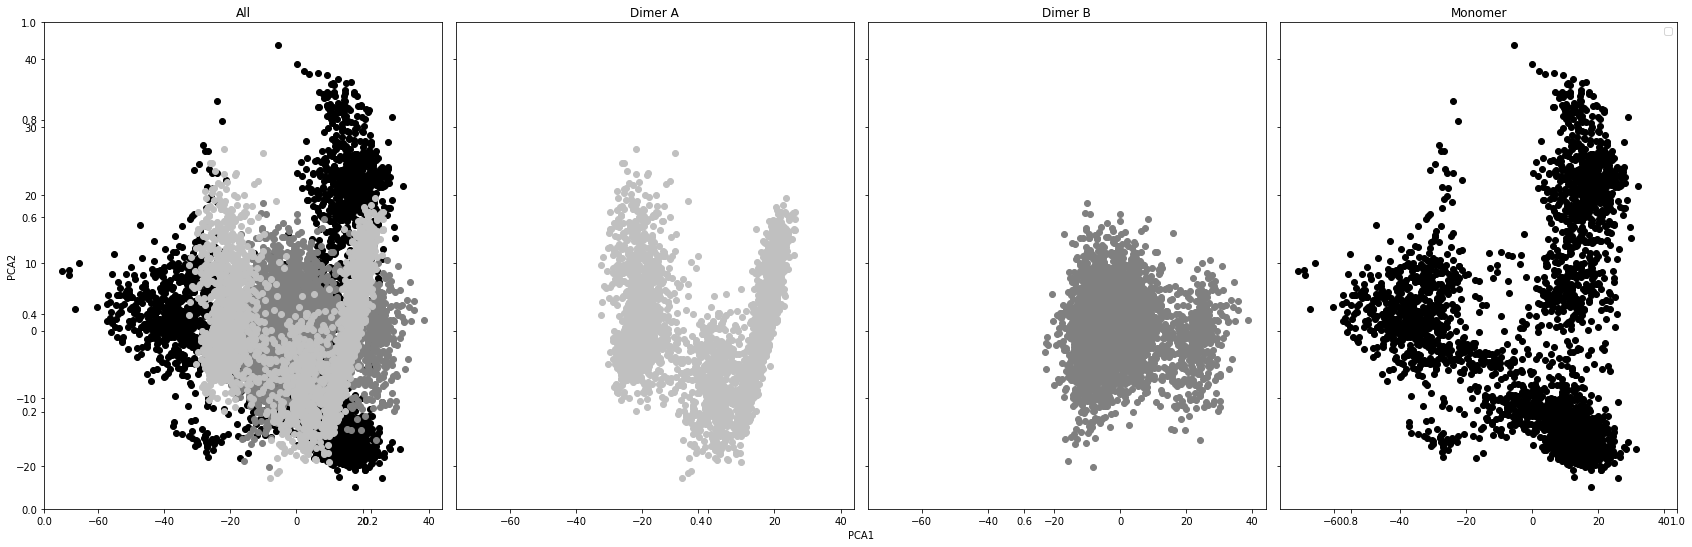

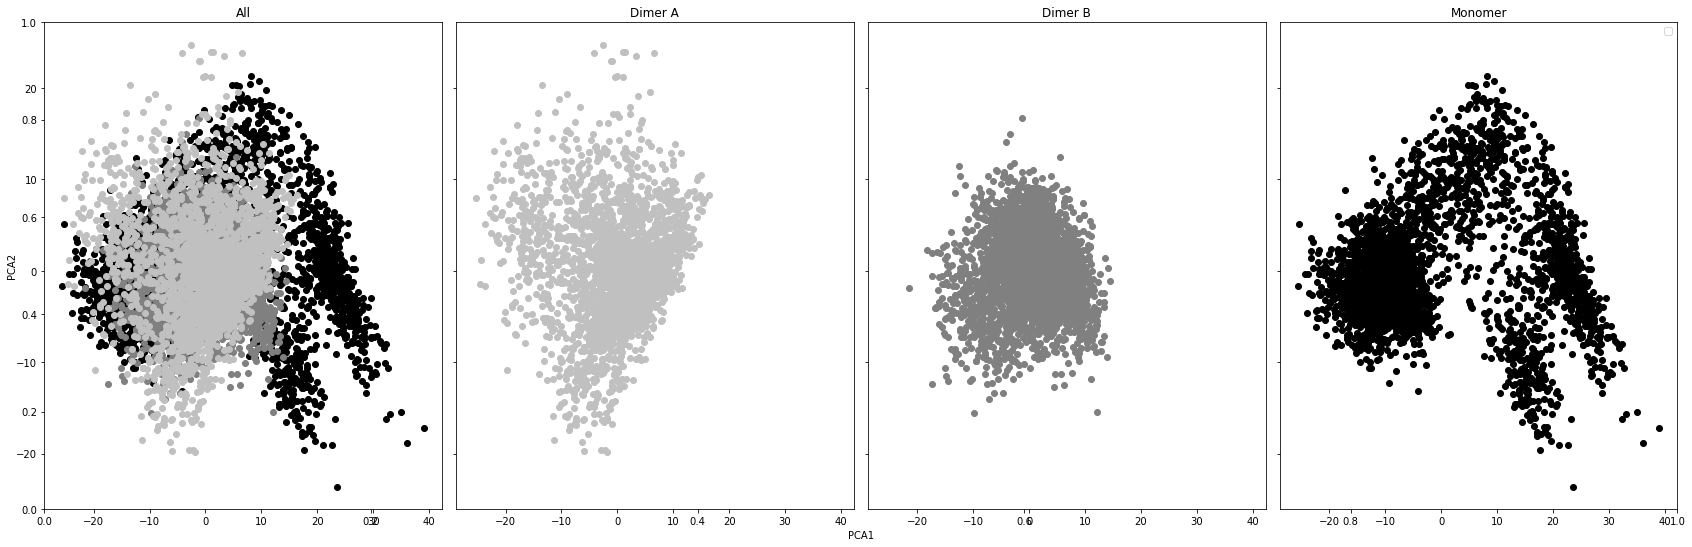

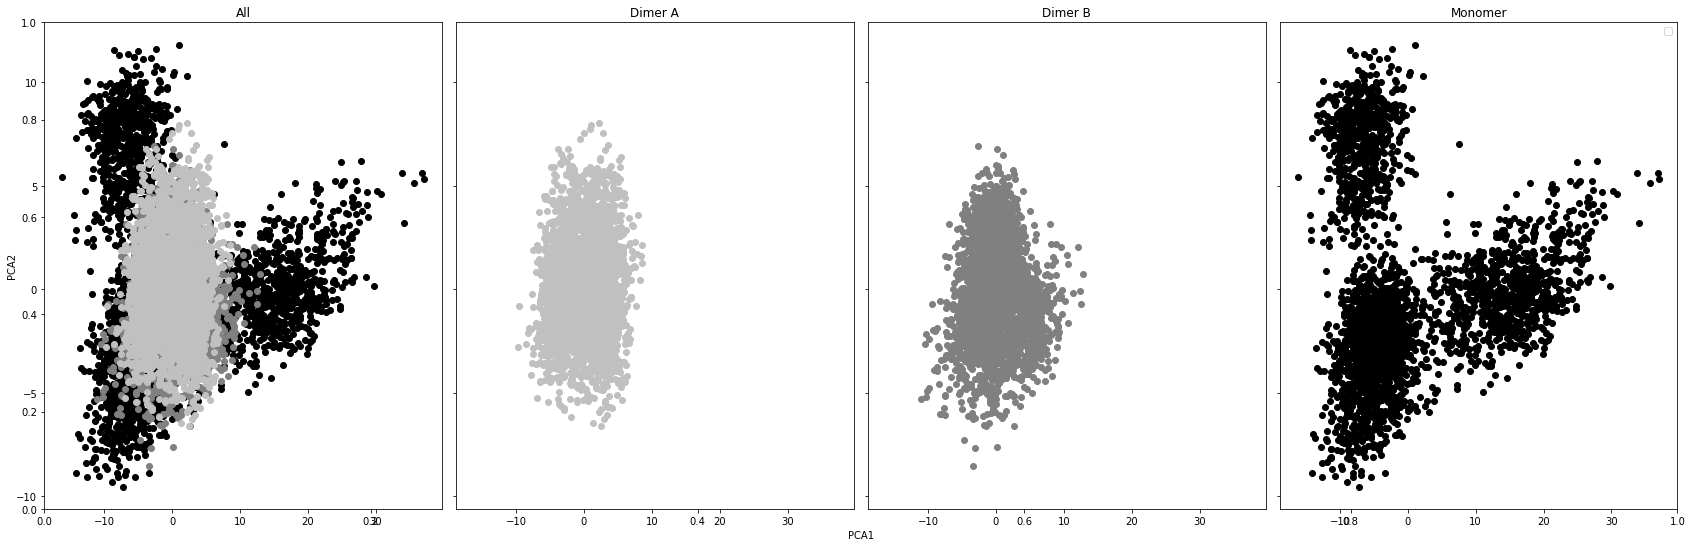

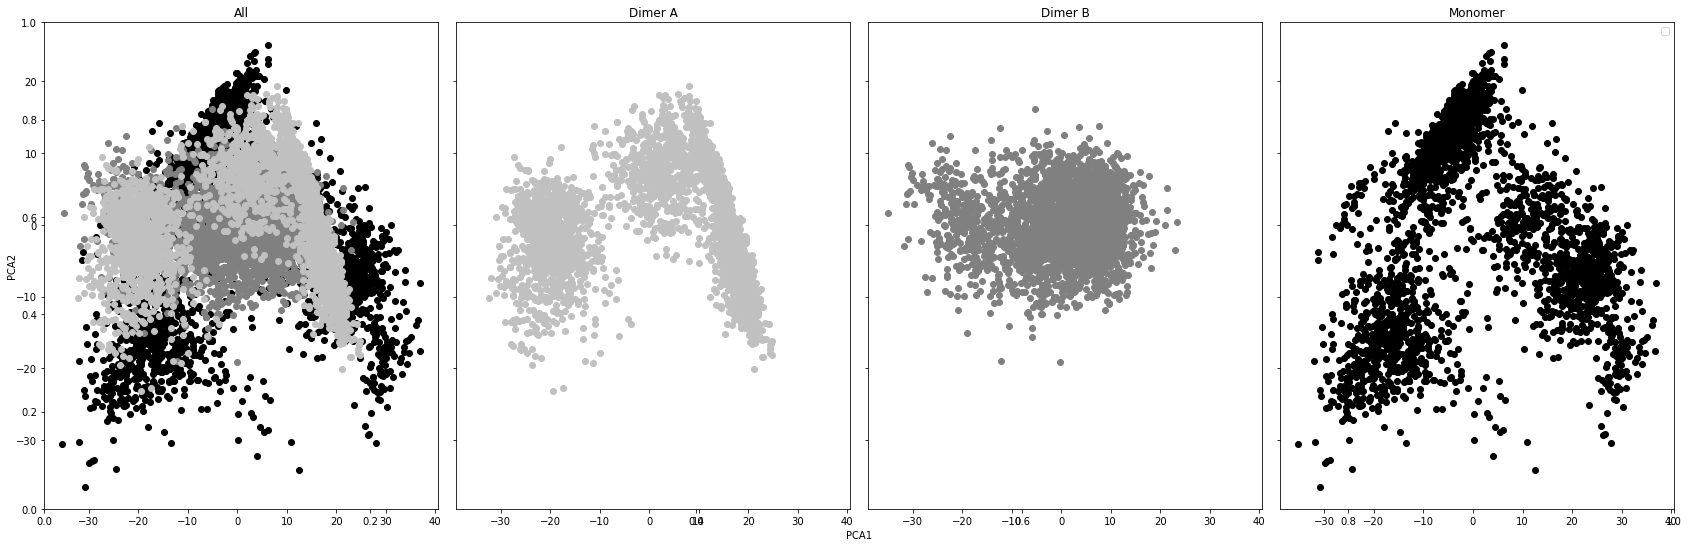

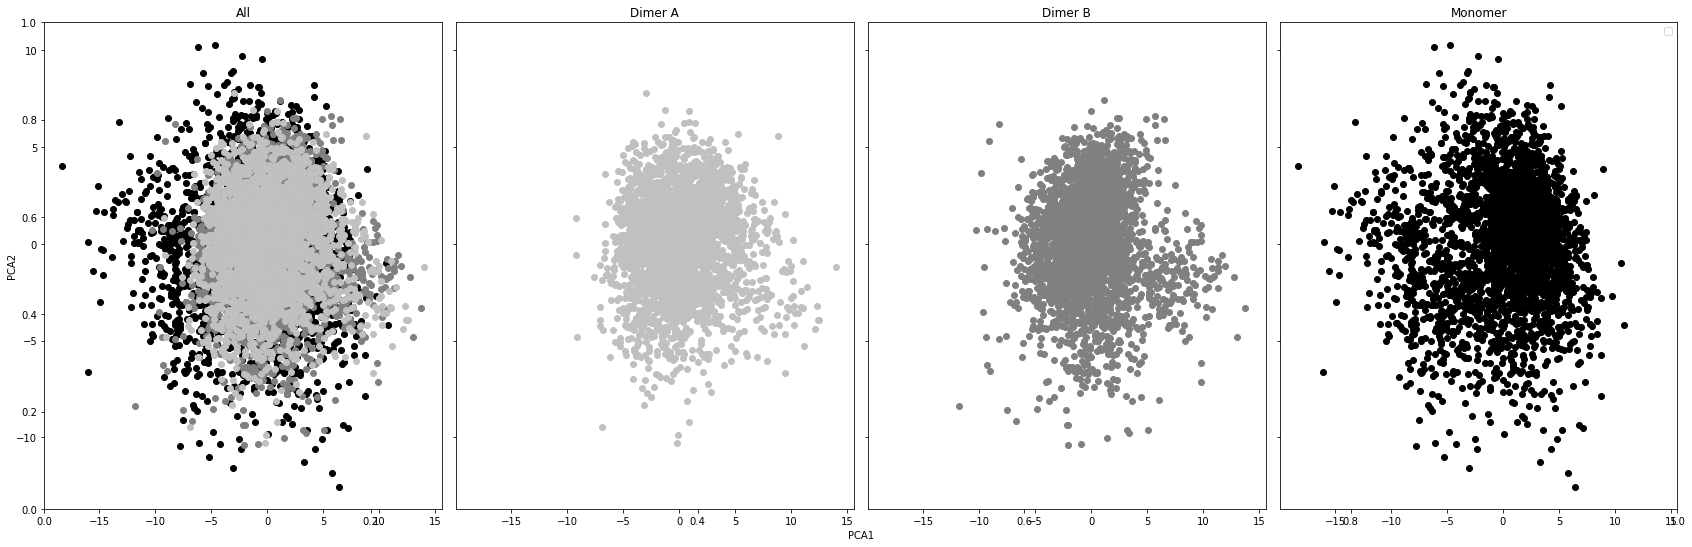

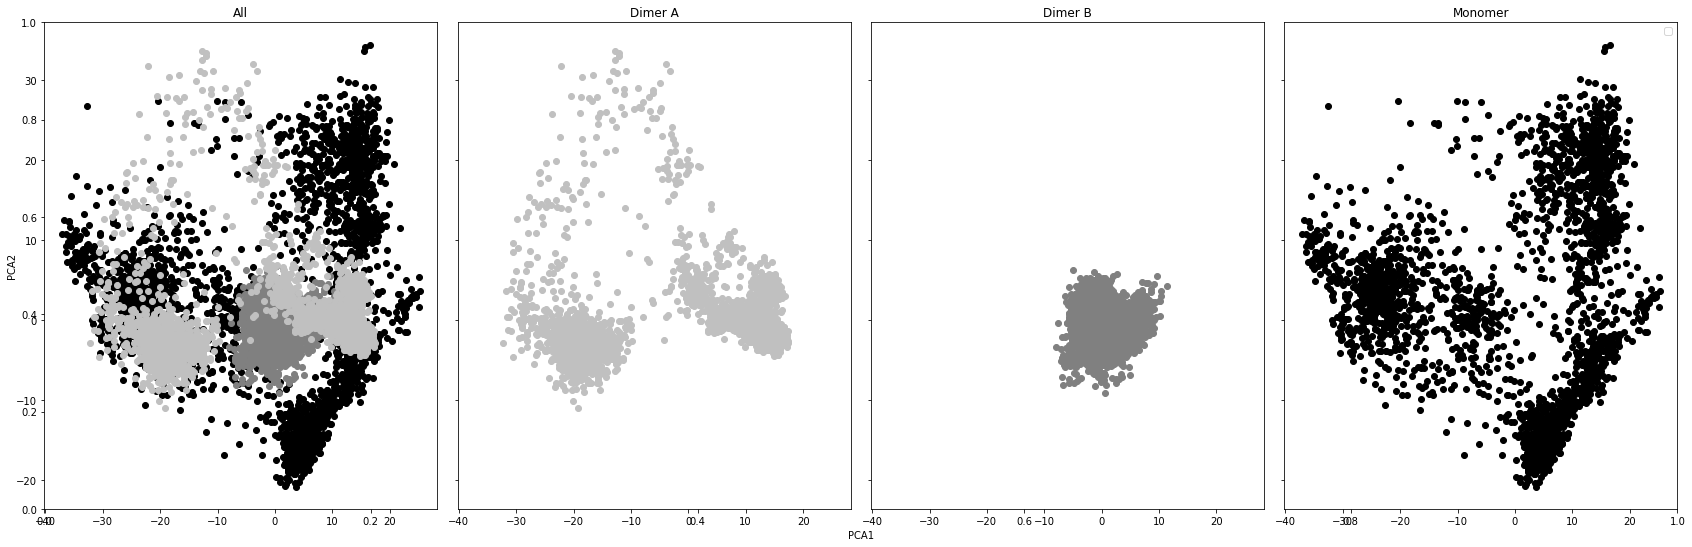

In [18]:
plot_pca(apo_monomer_pca,apo_dimer_a_pca,apo_dimer_b_pca,'protomer')
plot_pca(apo_monomer_pca,apo_dimer_a_pca,apo_dimer_b_pca,'domain1')
plot_pca(apo_monomer_pca,apo_dimer_a_pca,apo_dimer_b_pca,'domain2')
plot_pca(apo_monomer_pca,apo_dimer_a_pca,apo_dimer_b_pca,'domain3')
plot_pca(apo_monomer_pca,apo_dimer_a_pca,apo_dimer_b_pca,'idl')
plot_pca(apo_monomer_pca,apo_dimer_a_pca,apo_dimer_b_pca,'interface_ss')

### Peptide (Asymmetric)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


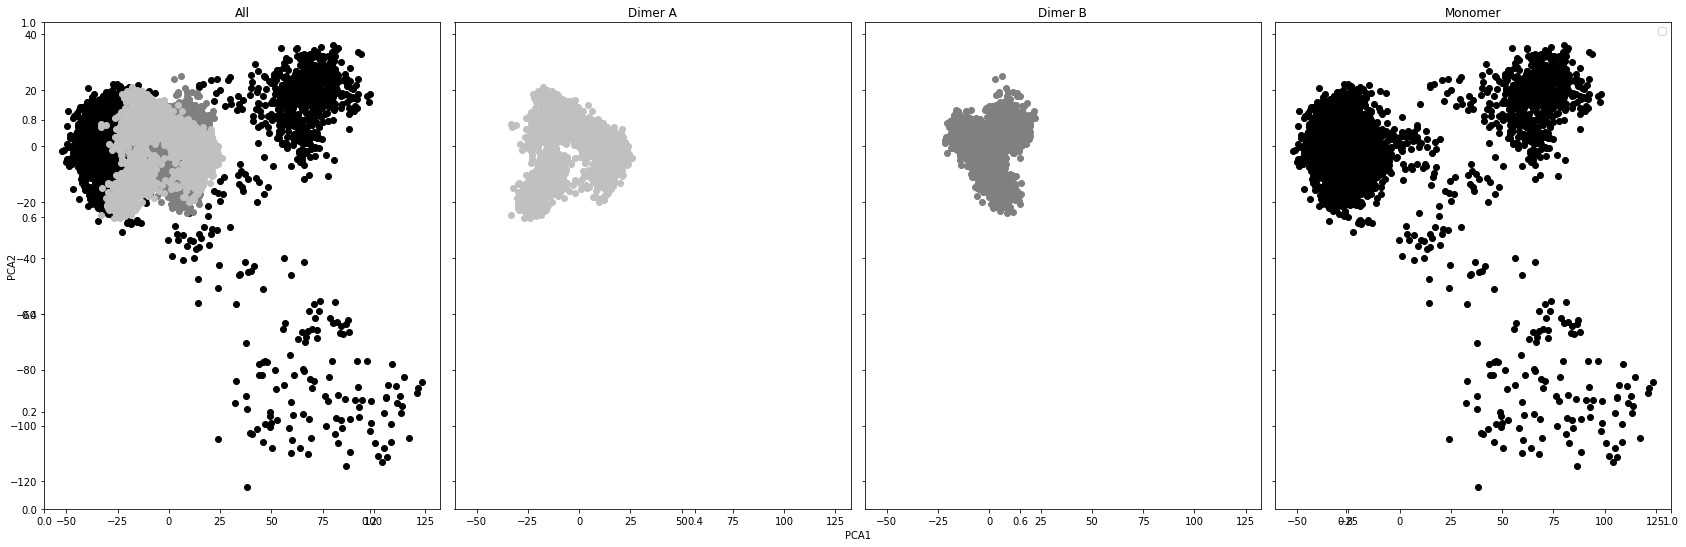

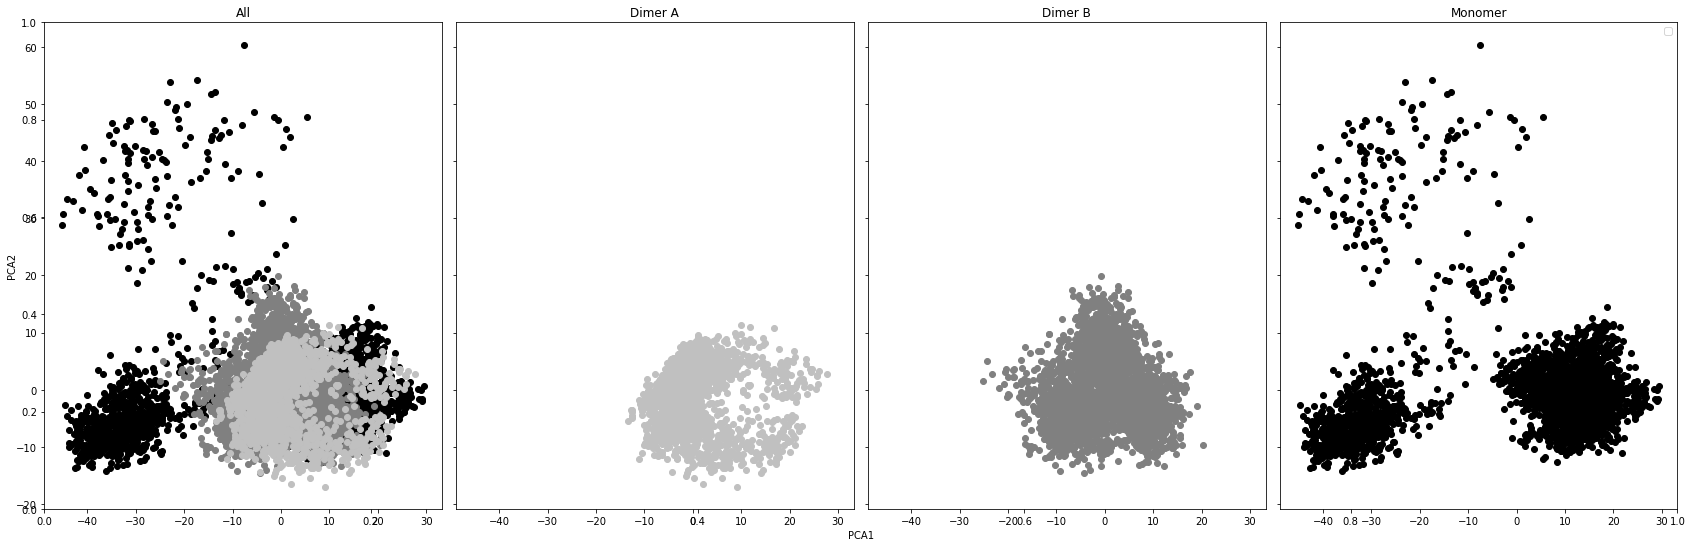

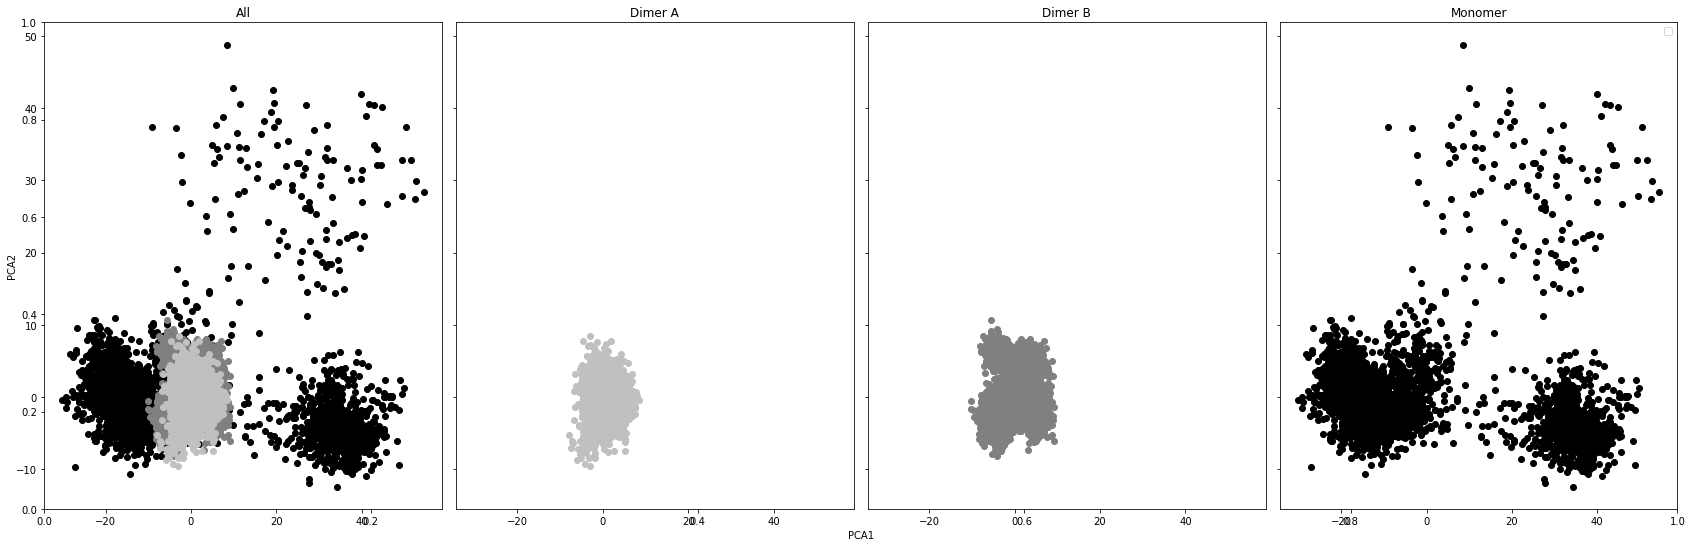

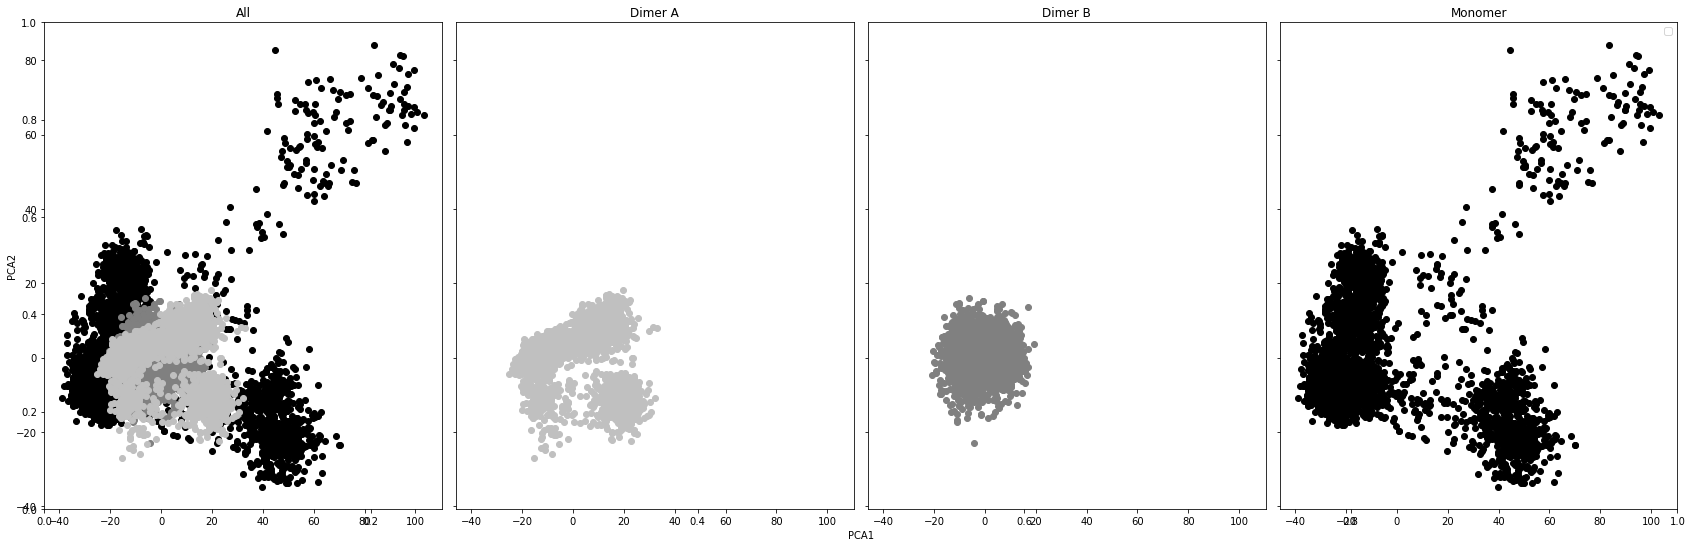

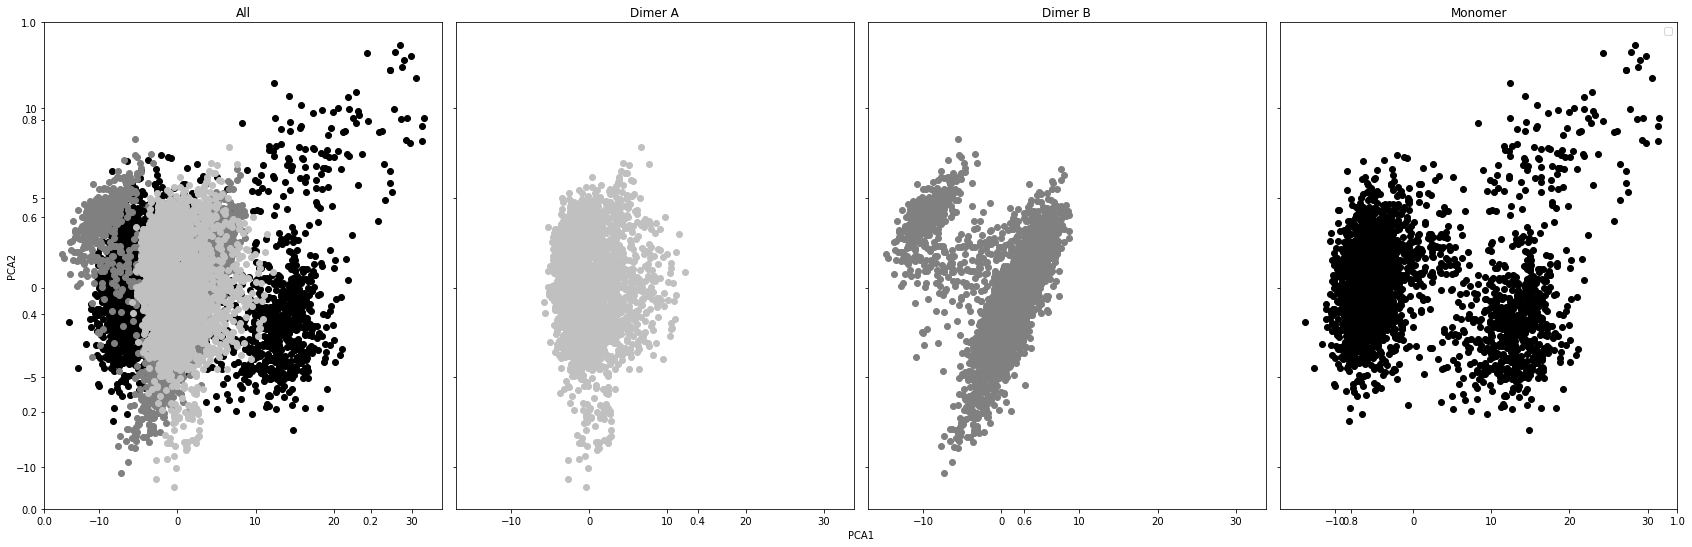

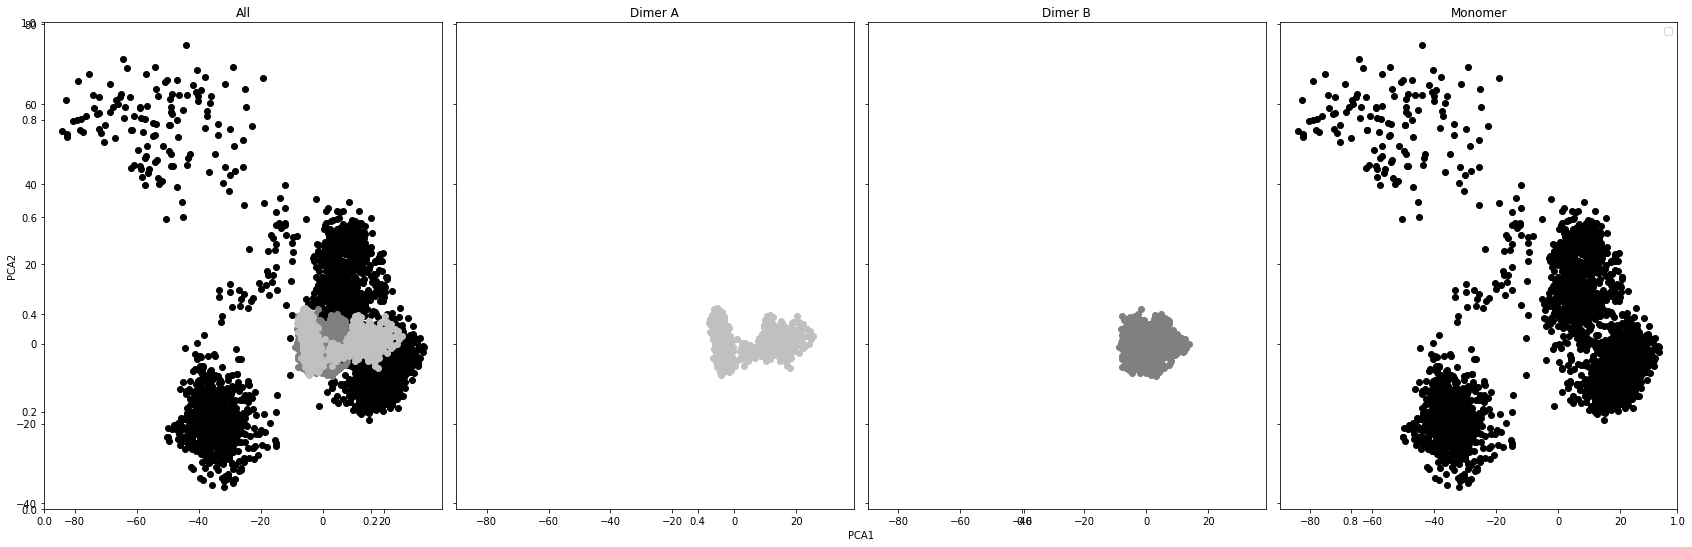

In [19]:
plot_pca(nat_monomer_pca,nat_asym_a_pca,nat_asym_b_pca,'protomer')
plot_pca(nat_monomer_pca,nat_asym_a_pca,nat_asym_b_pca,'domain1')
plot_pca(nat_monomer_pca,nat_asym_a_pca,nat_asym_b_pca,'domain2')
plot_pca(nat_monomer_pca,nat_asym_a_pca,nat_asym_b_pca,'domain3')
plot_pca(nat_monomer_pca,nat_asym_a_pca,nat_asym_b_pca,'idl')
plot_pca(nat_monomer_pca,nat_asym_a_pca,nat_asym_b_pca,'interface_ss')

### Peptide (Fully bound)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


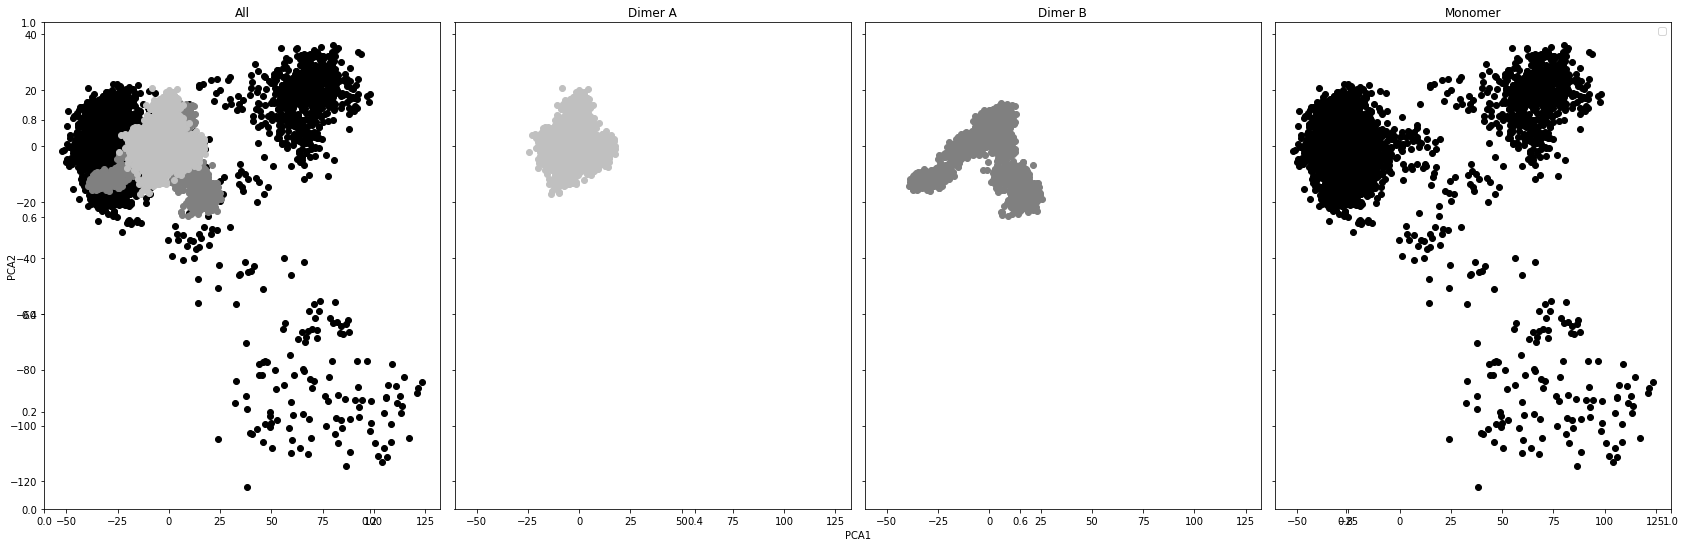

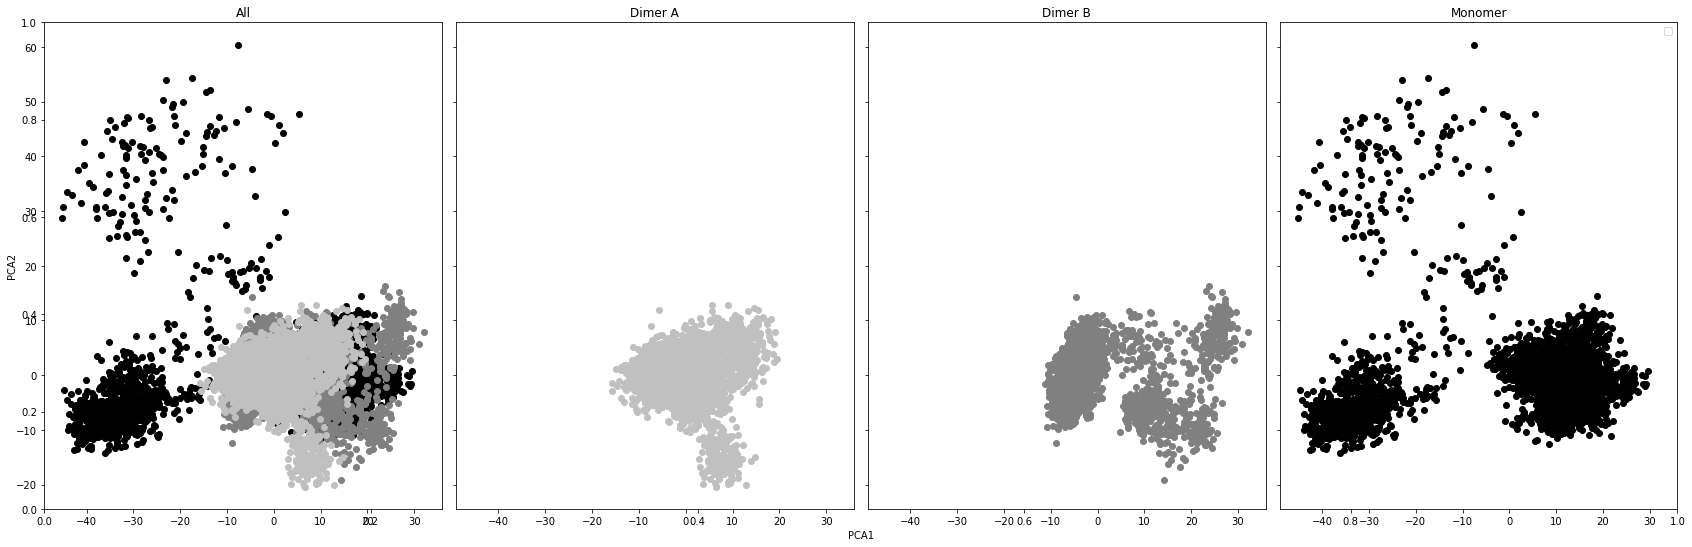

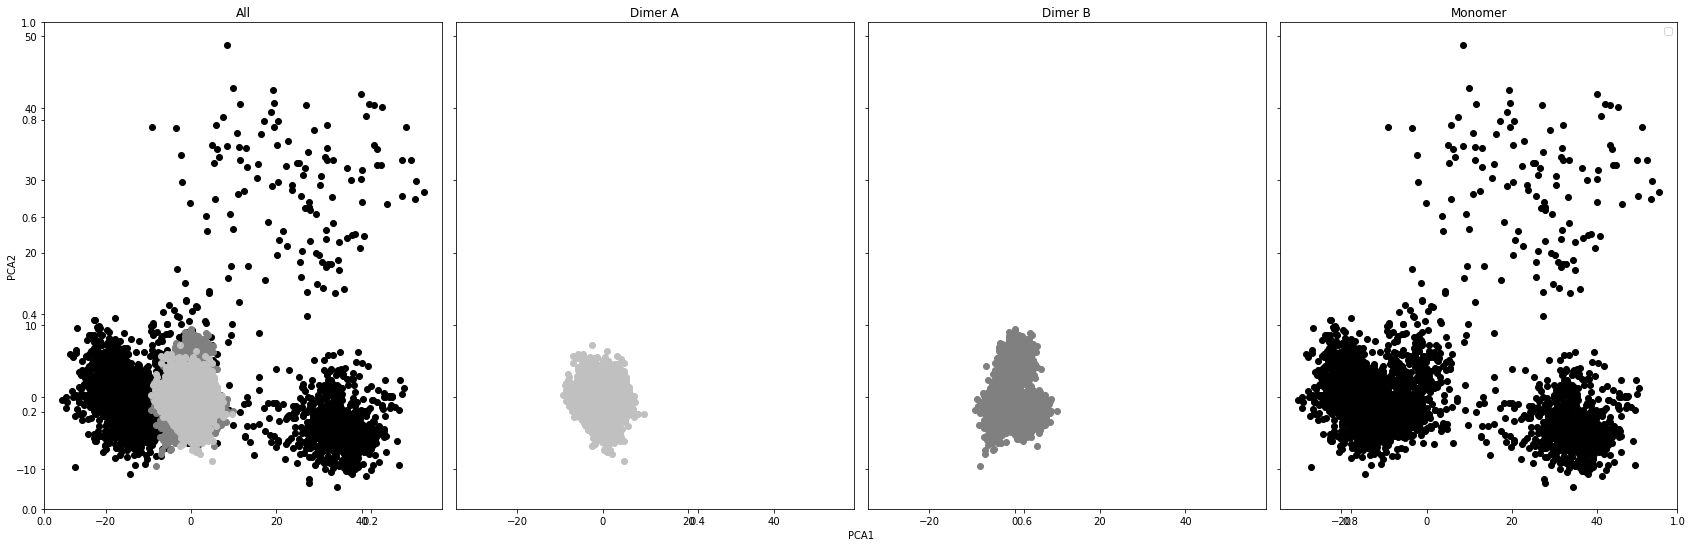

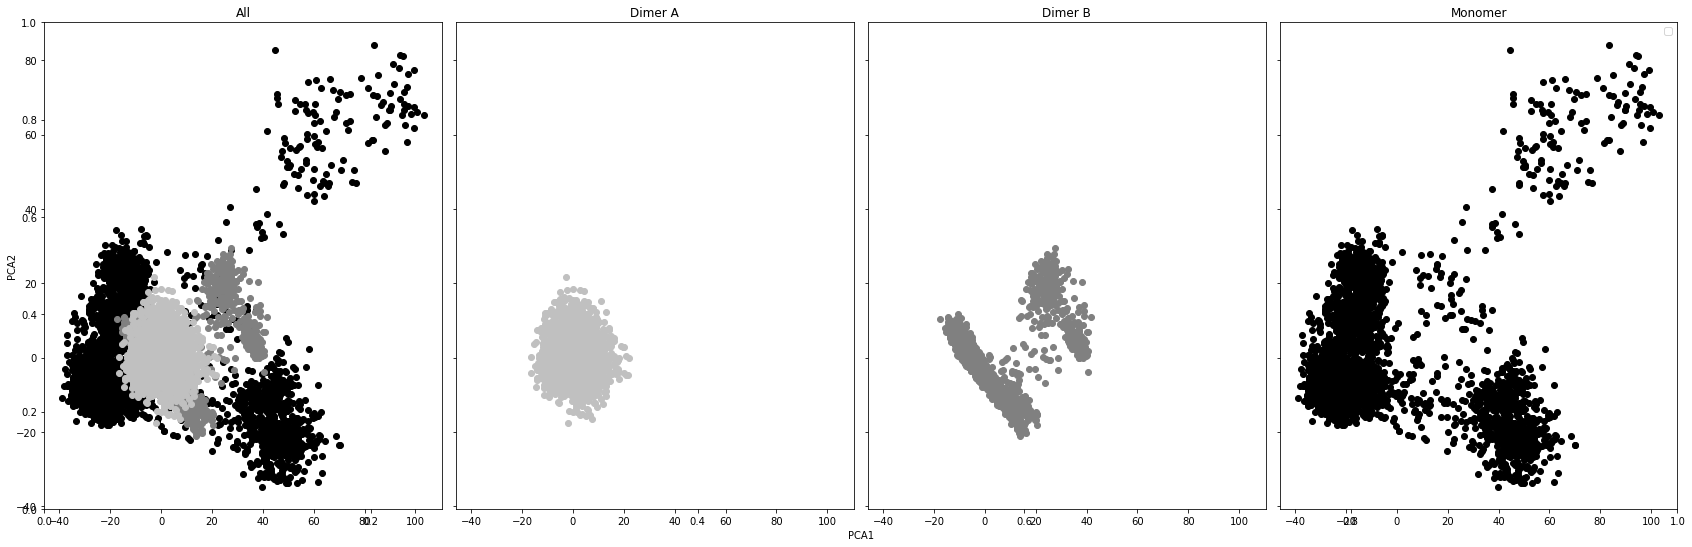

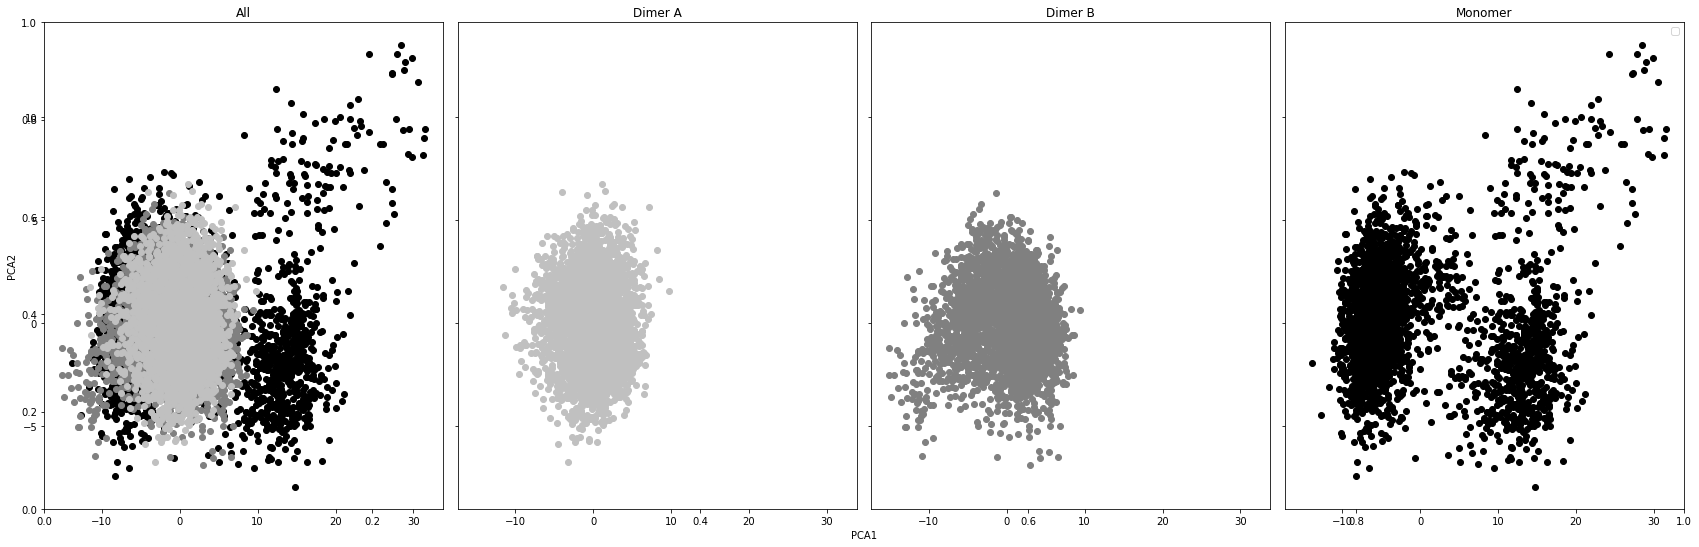

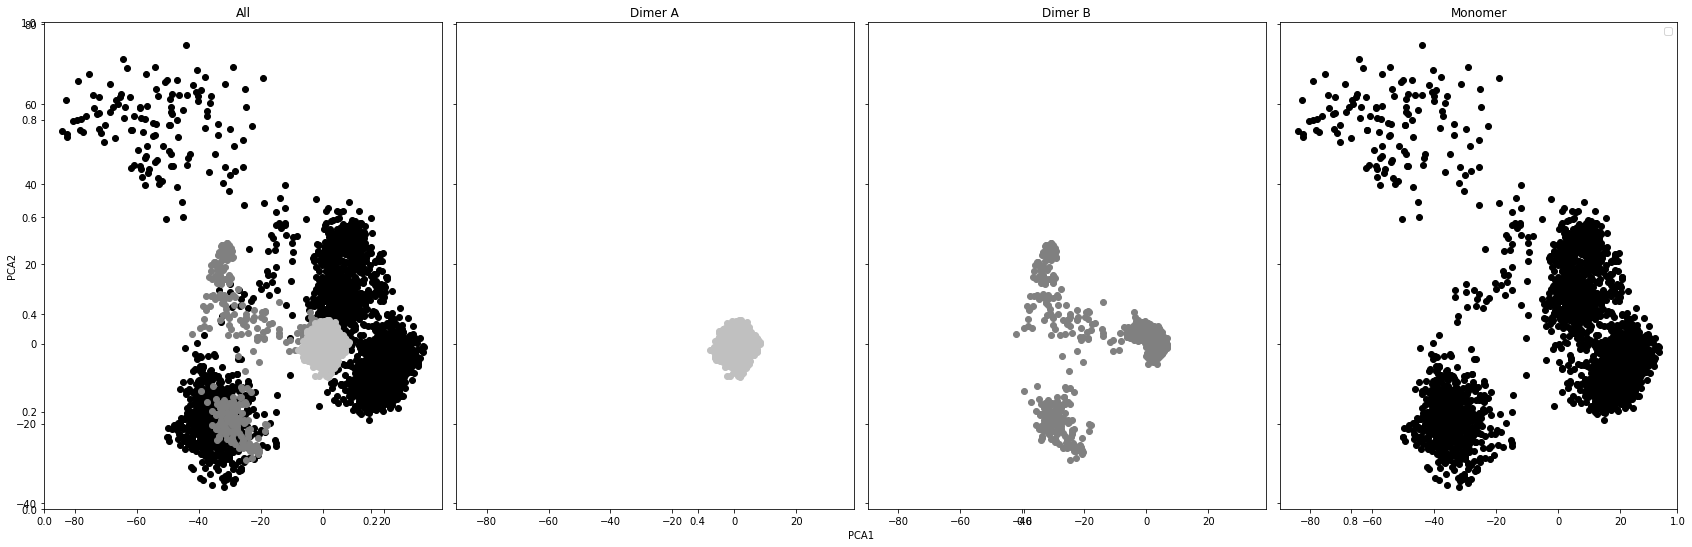

In [20]:
plot_pca(nat_monomer_pca,nat_dimer_a_pca,nat_dimer_b_pca,'protomer')
plot_pca(nat_monomer_pca,nat_dimer_a_pca,nat_dimer_b_pca,'domain1')
plot_pca(nat_monomer_pca,nat_dimer_a_pca,nat_dimer_b_pca,'domain2')
plot_pca(nat_monomer_pca,nat_dimer_a_pca,nat_dimer_b_pca,'domain3')
plot_pca(nat_monomer_pca,nat_dimer_a_pca,nat_dimer_b_pca,'idl')
plot_pca(nat_monomer_pca,nat_dimer_a_pca,nat_dimer_b_pca,'interface_ss')

### Nirm Dimer (Asymmetric)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


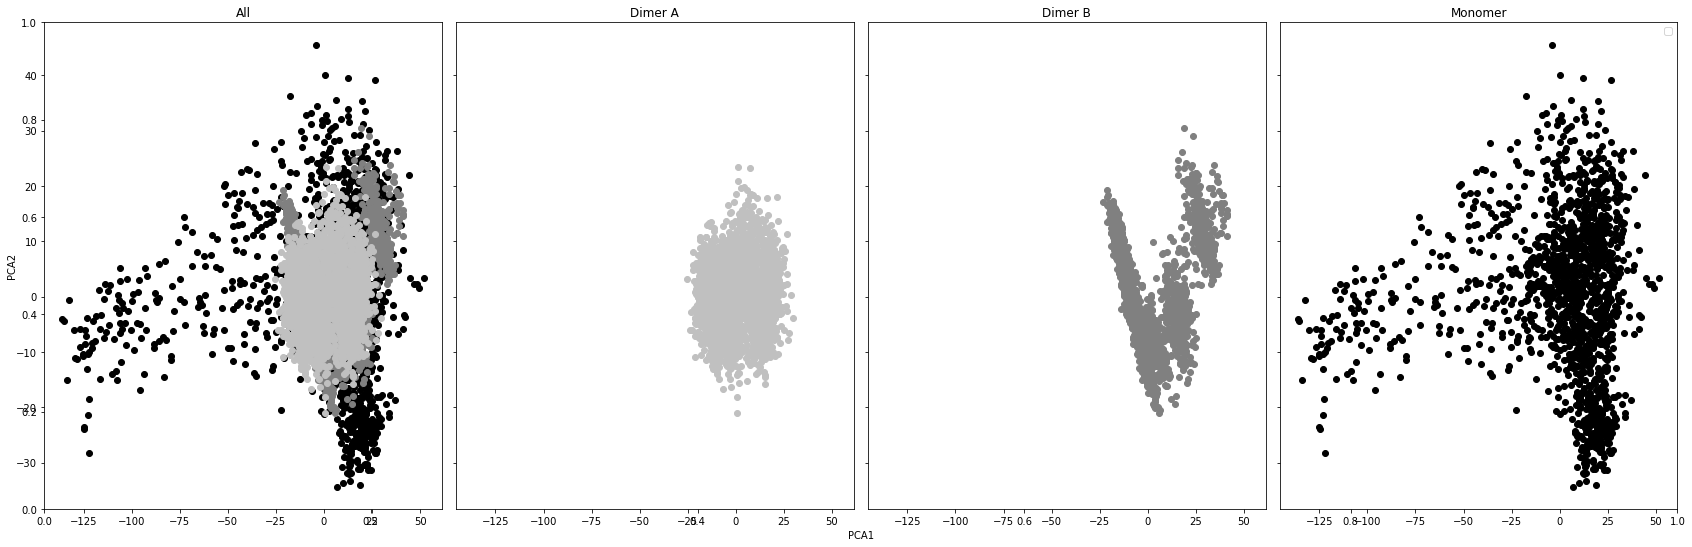

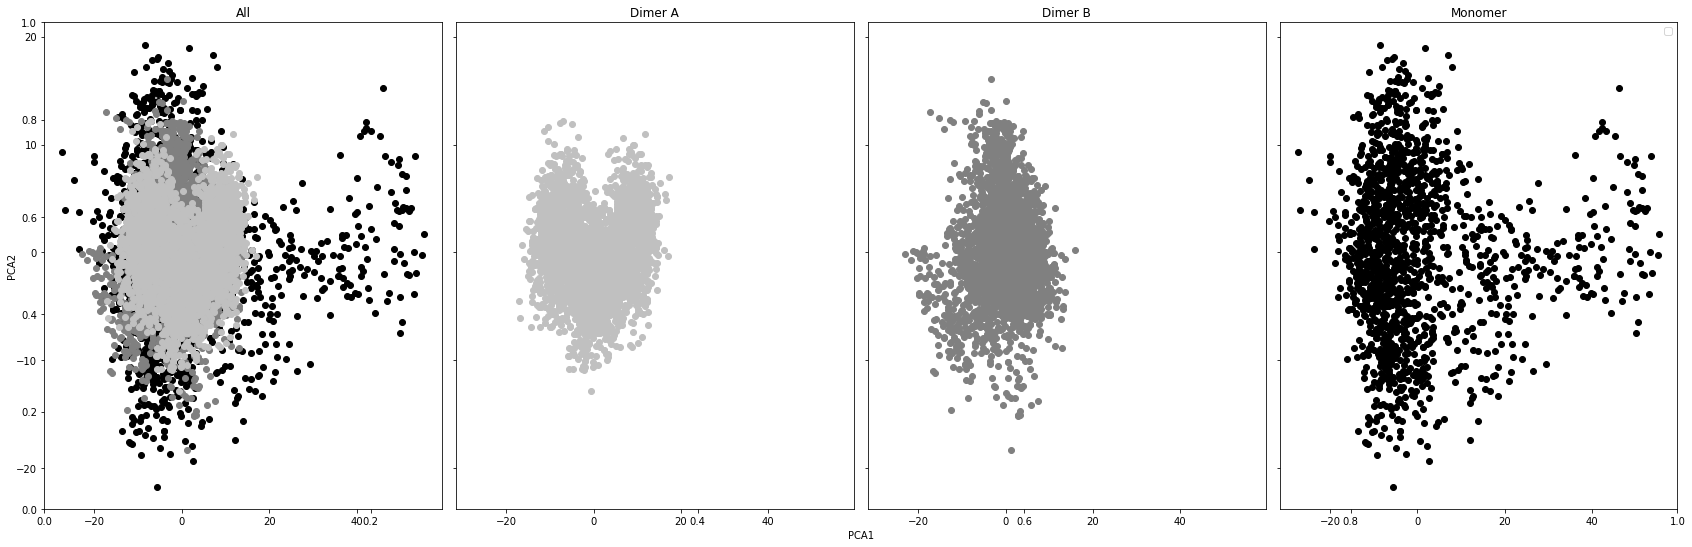

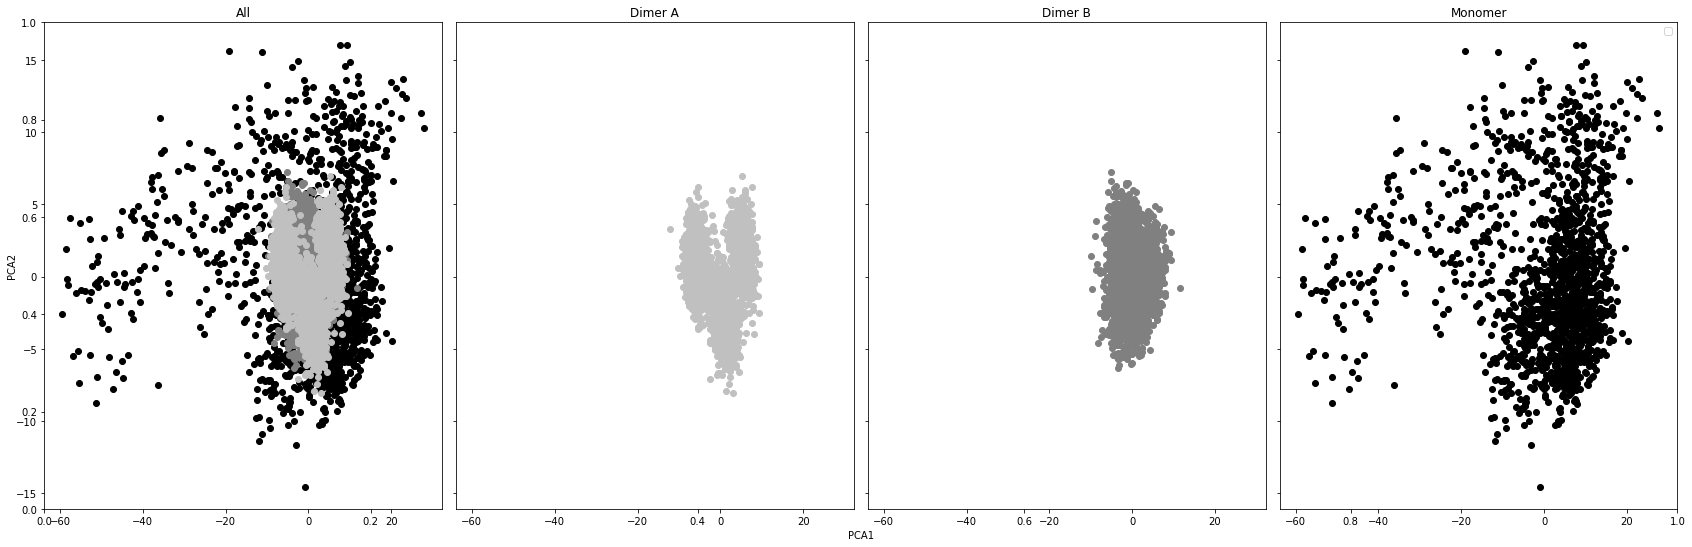

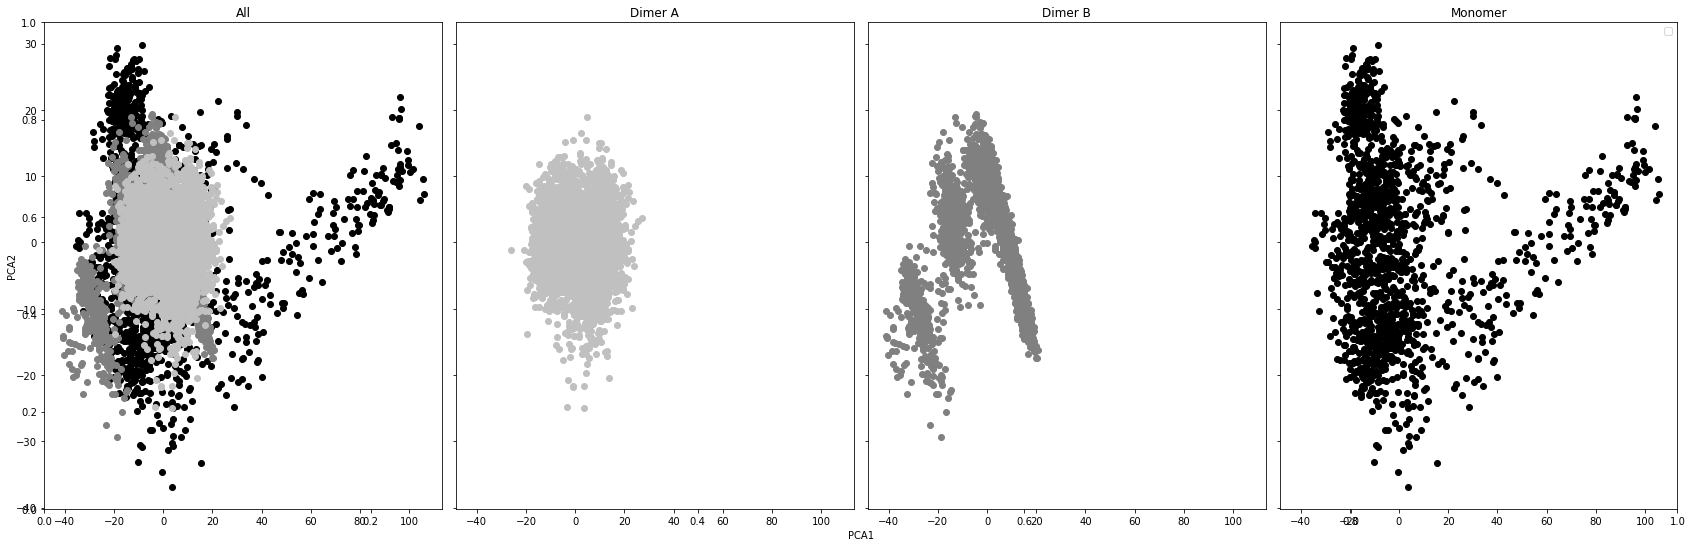

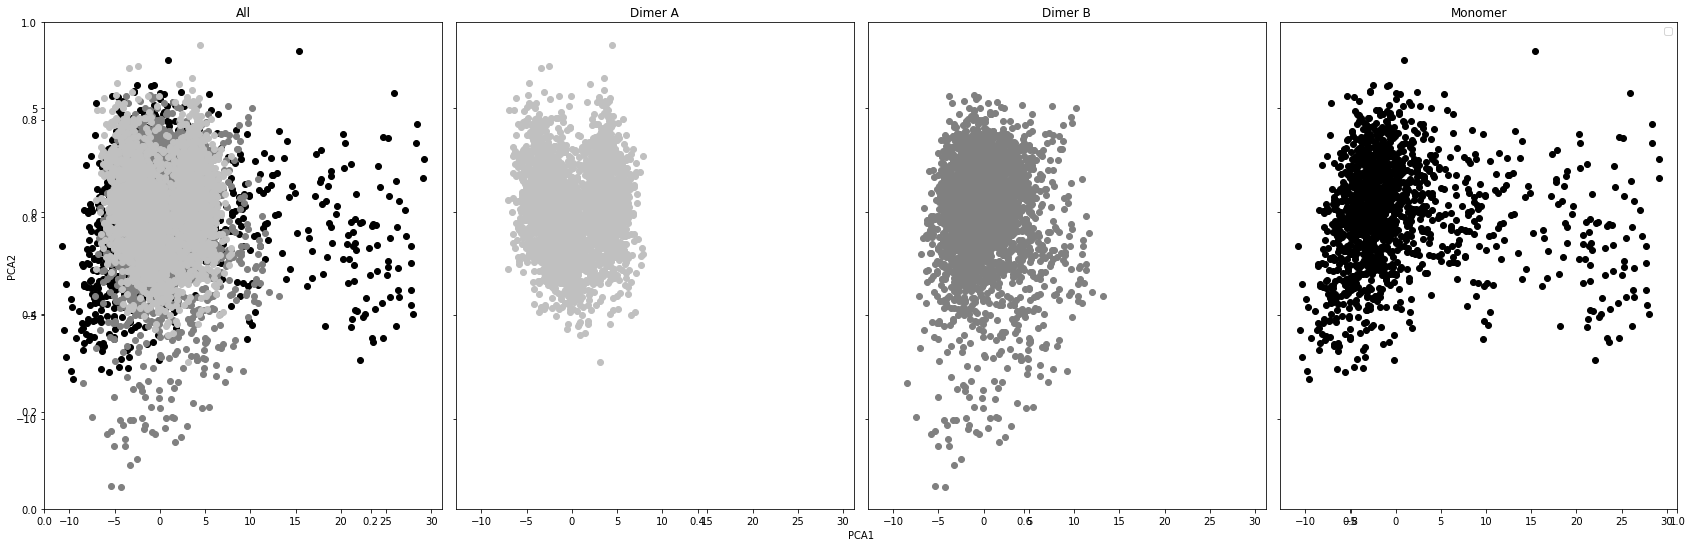

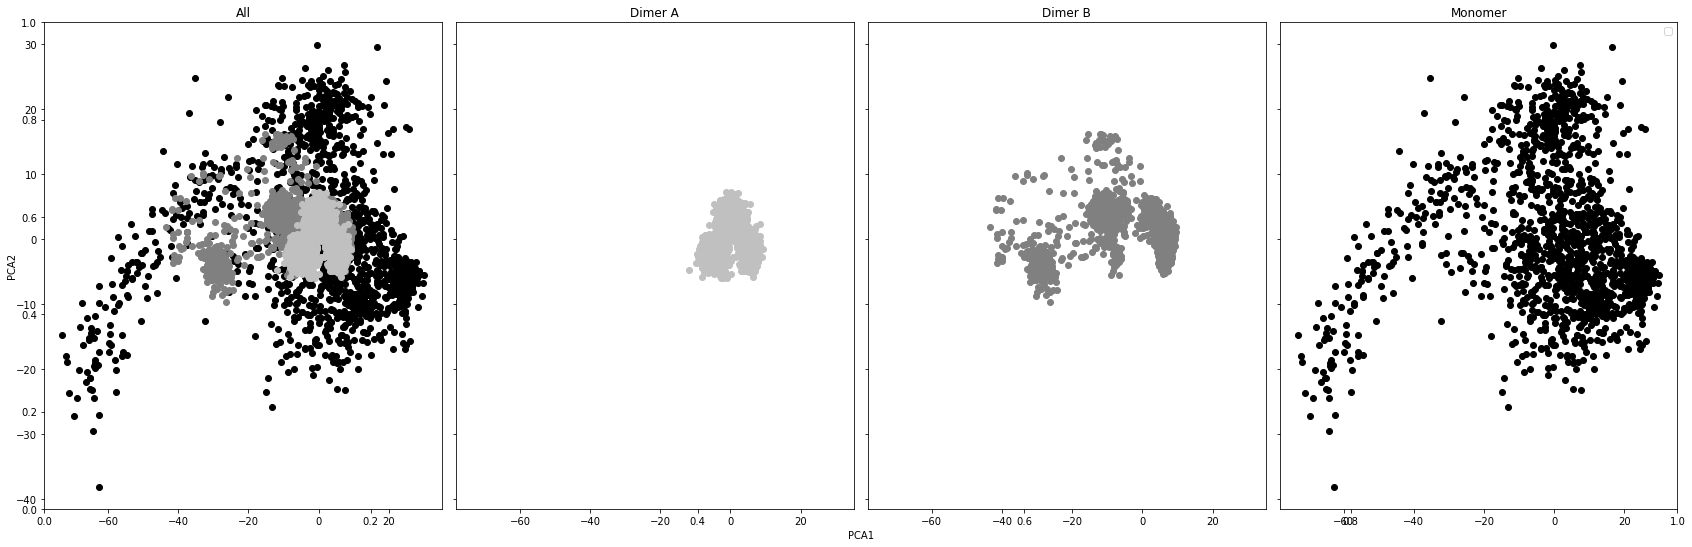

In [21]:
plot_pca(nirm_monomer_pca,nirm_asym_b_pca,nirm_asym_a_pca,'protomer')
plot_pca(nirm_monomer_pca,nirm_asym_b_pca,nirm_asym_a_pca,'domain1')
plot_pca(nirm_monomer_pca,nirm_asym_b_pca,nirm_asym_a_pca,'domain2')
plot_pca(nirm_monomer_pca,nirm_asym_b_pca,nirm_asym_a_pca,'domain3')
plot_pca(nirm_monomer_pca,nirm_asym_b_pca,nirm_asym_a_pca,'idl')
plot_pca(nirm_monomer_pca,nirm_asym_b_pca,nirm_asym_a_pca,'interface_ss')

### Nirm Dimer (Fully Bound)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


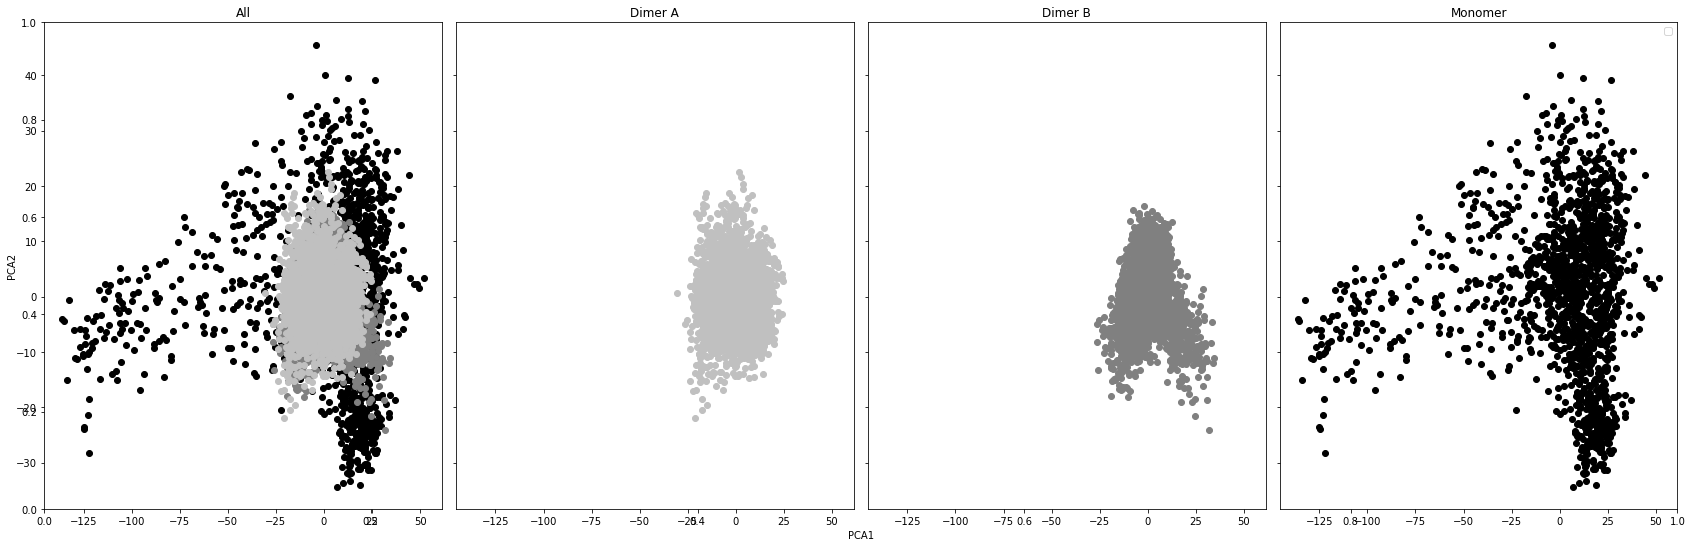

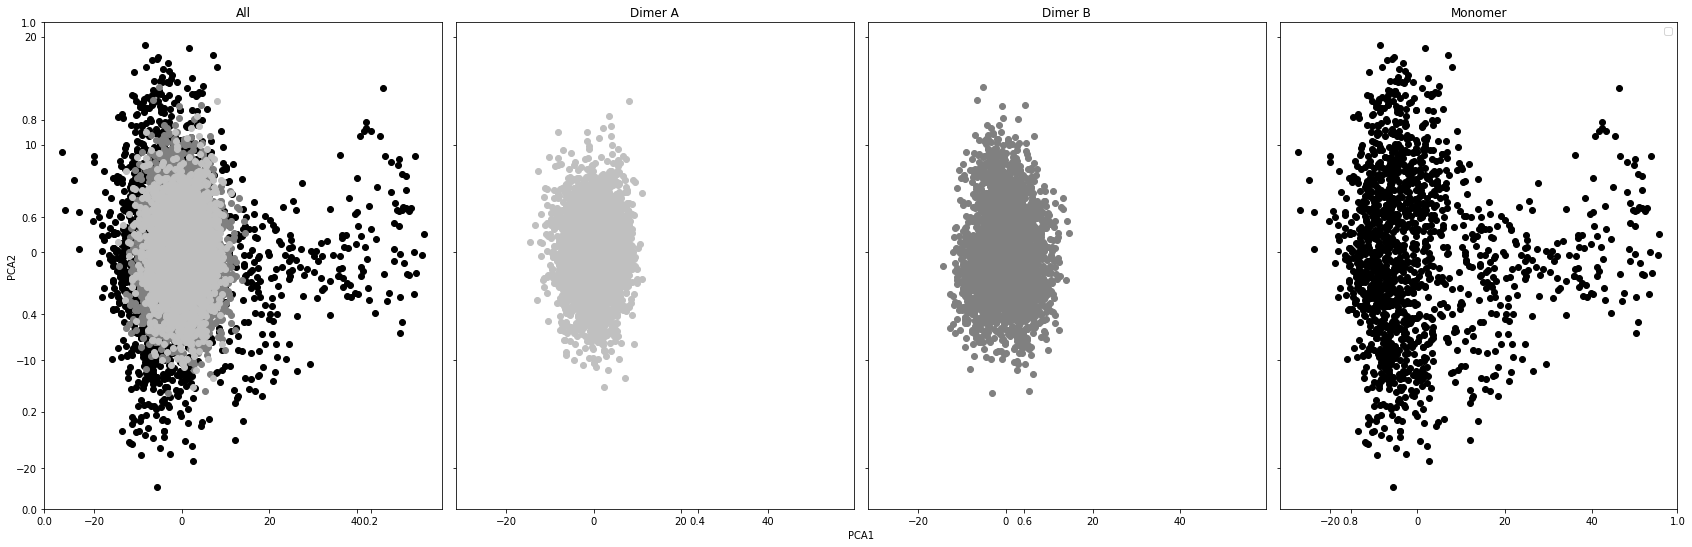

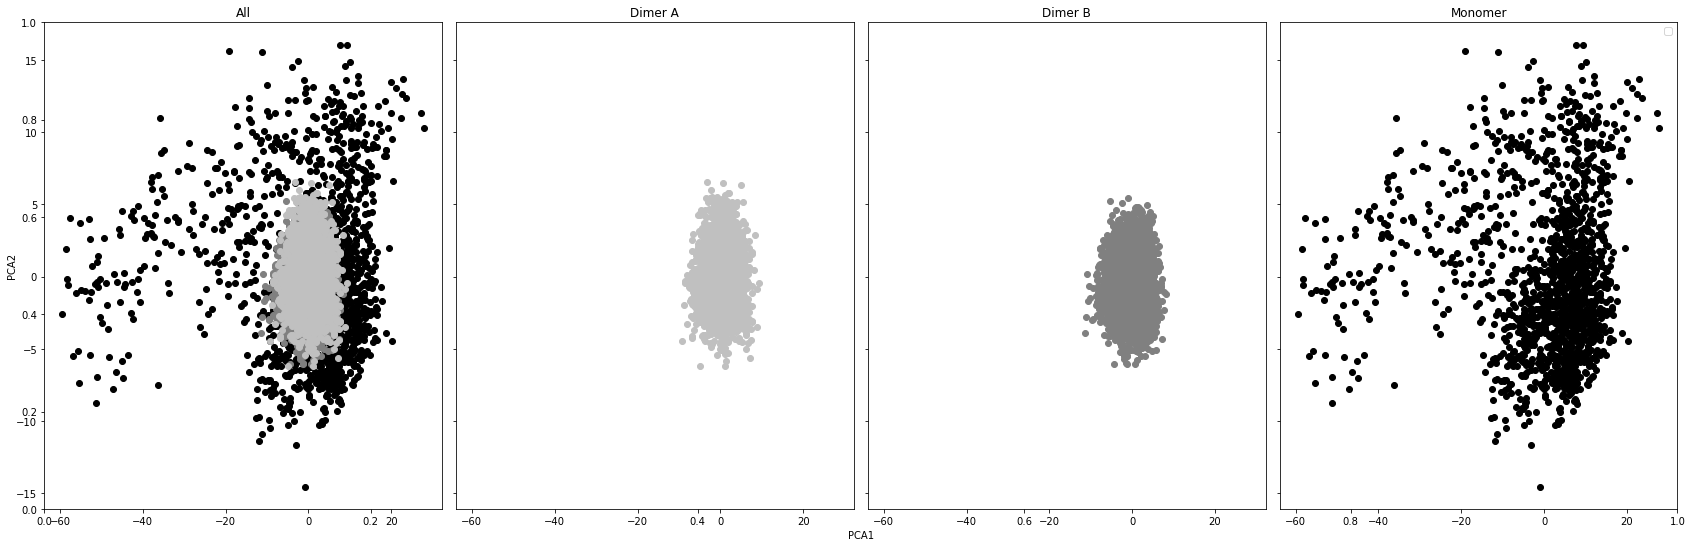

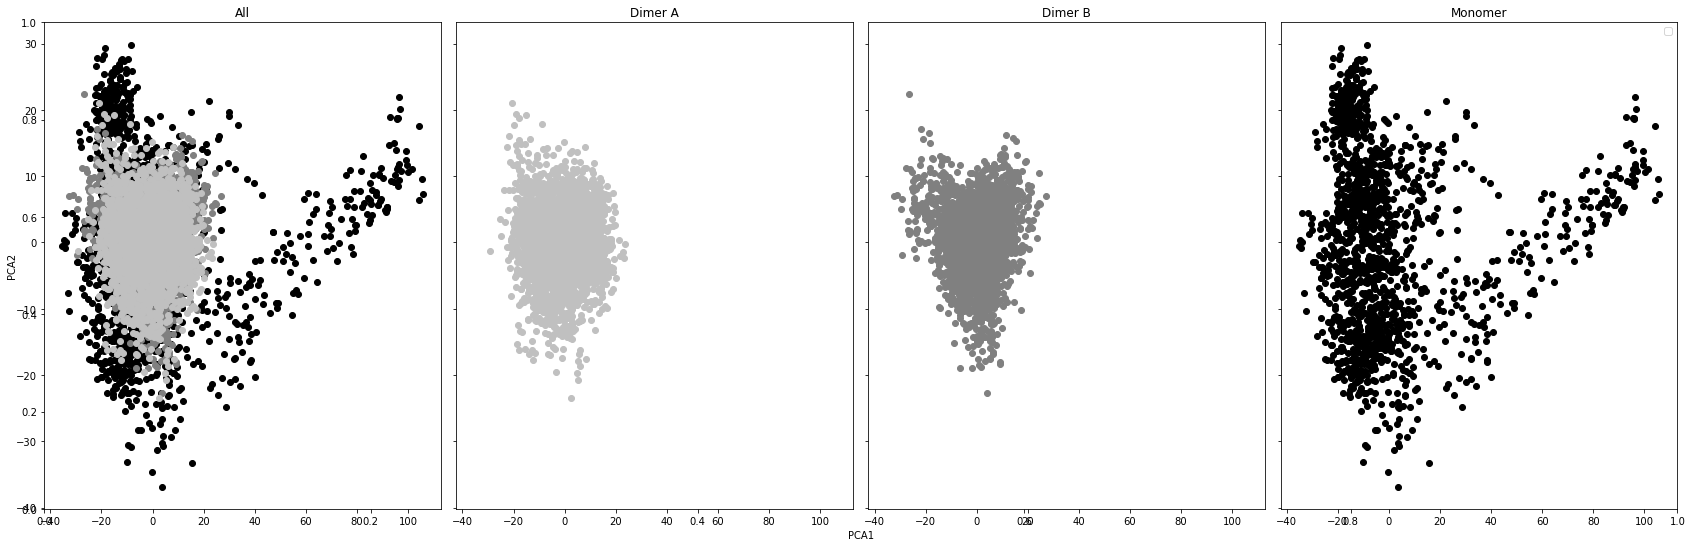

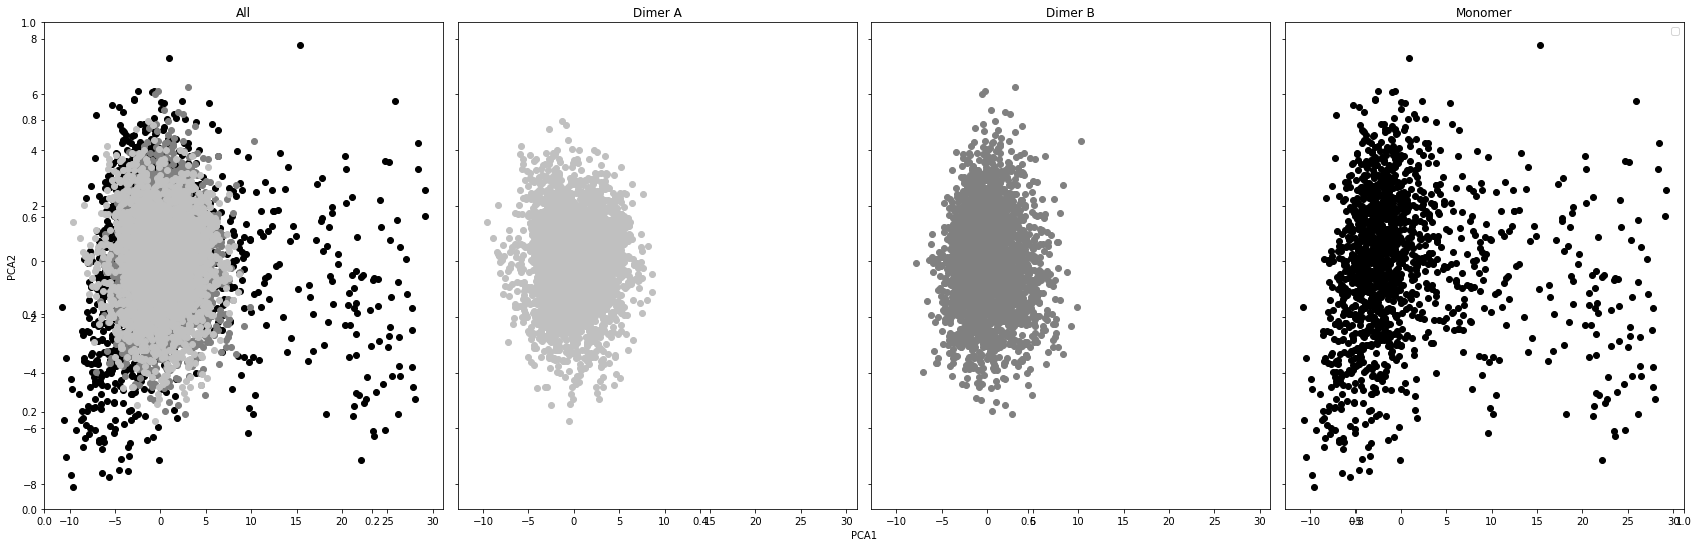

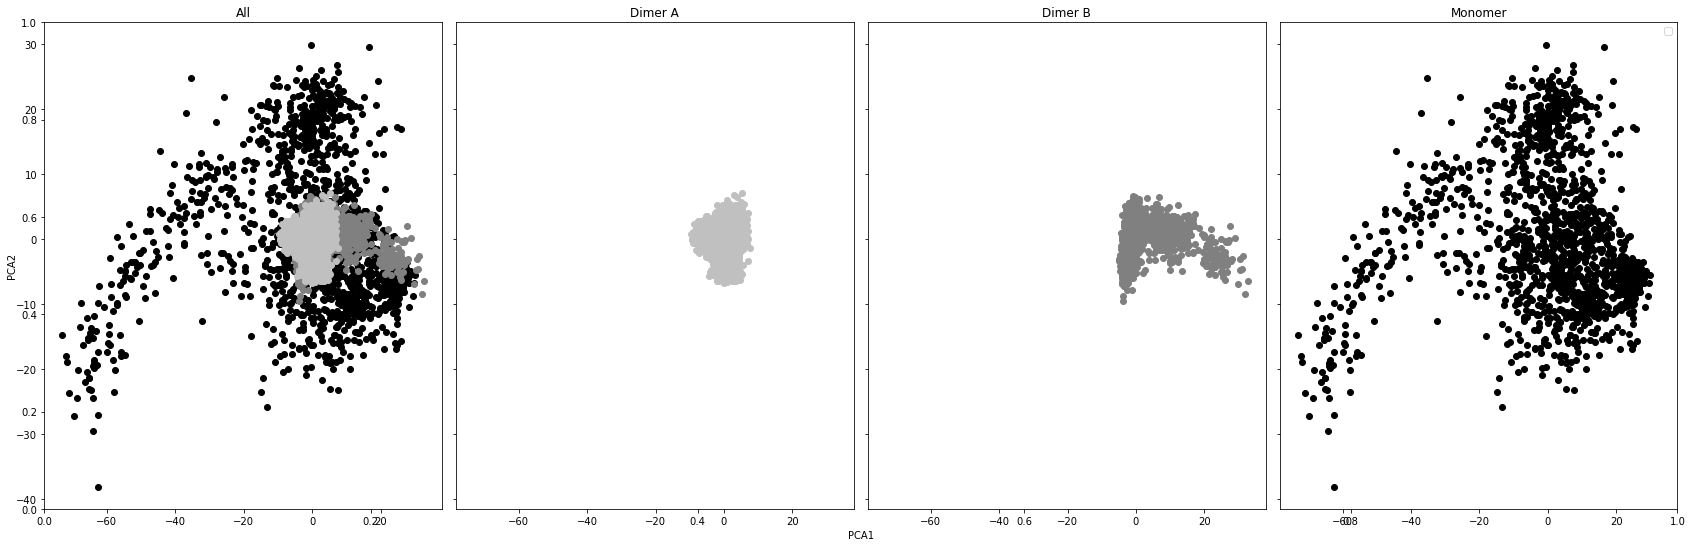

In [22]:
plot_pca(nirm_monomer_pca,nirm_dimer_b_pca,nirm_dimer_a_pca,'protomer')
plot_pca(nirm_monomer_pca,nirm_dimer_b_pca,nirm_dimer_a_pca,'domain1')
plot_pca(nirm_monomer_pca,nirm_dimer_b_pca,nirm_dimer_a_pca,'domain2')
plot_pca(nirm_monomer_pca,nirm_dimer_b_pca,nirm_dimer_a_pca,'domain3')
plot_pca(nirm_monomer_pca,nirm_dimer_b_pca,nirm_dimer_a_pca,'idl')
plot_pca(nirm_monomer_pca,nirm_dimer_b_pca,nirm_dimer_a_pca,'interface_ss')

### Ens (Asymmetric)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


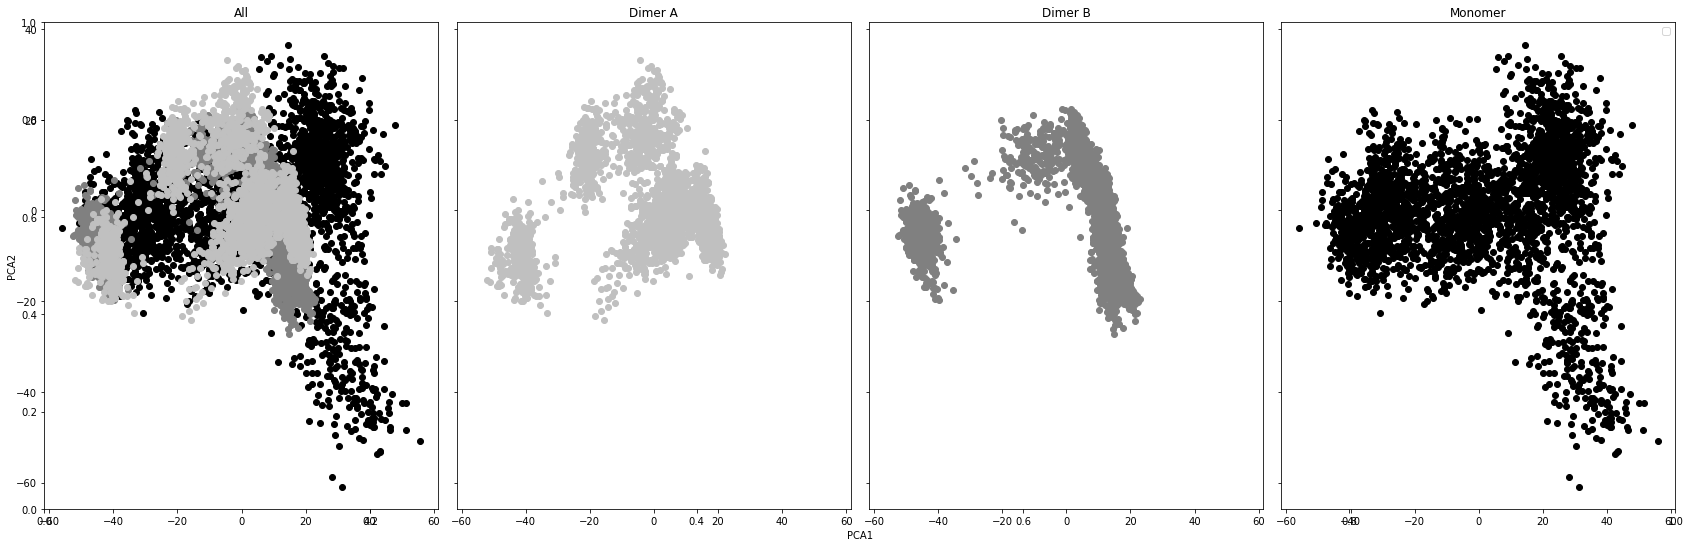

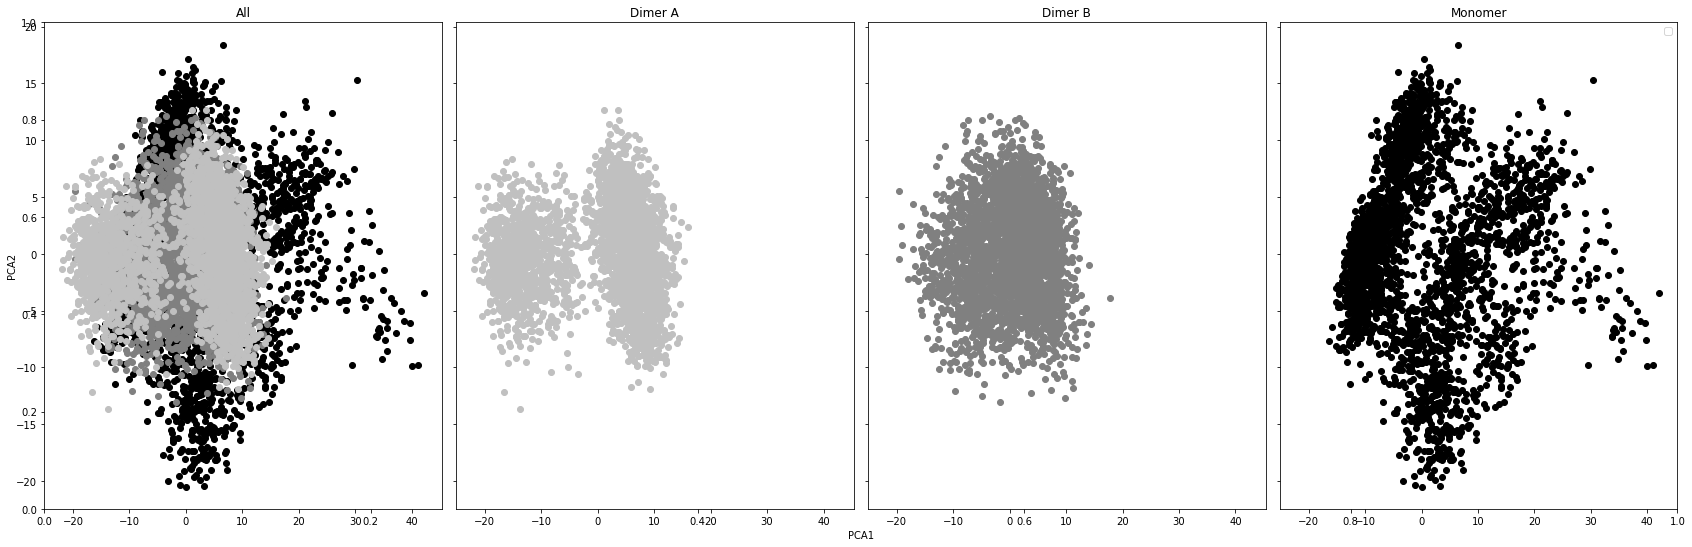

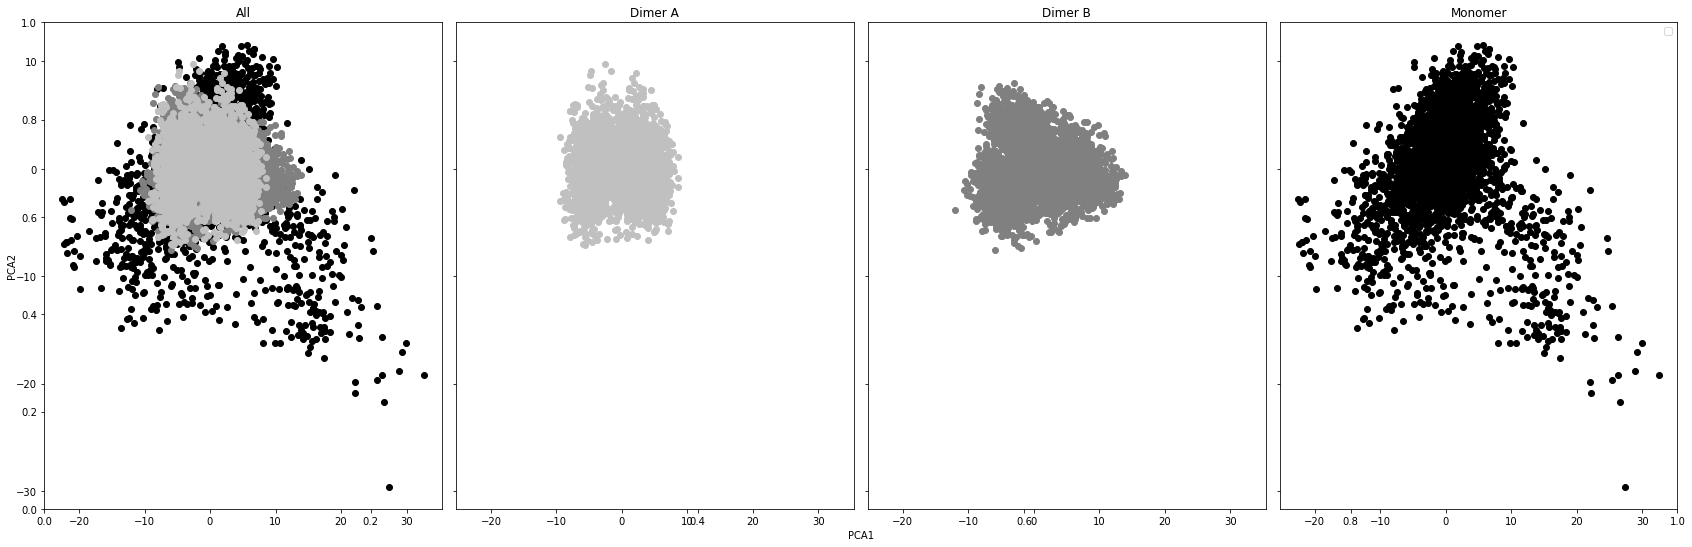

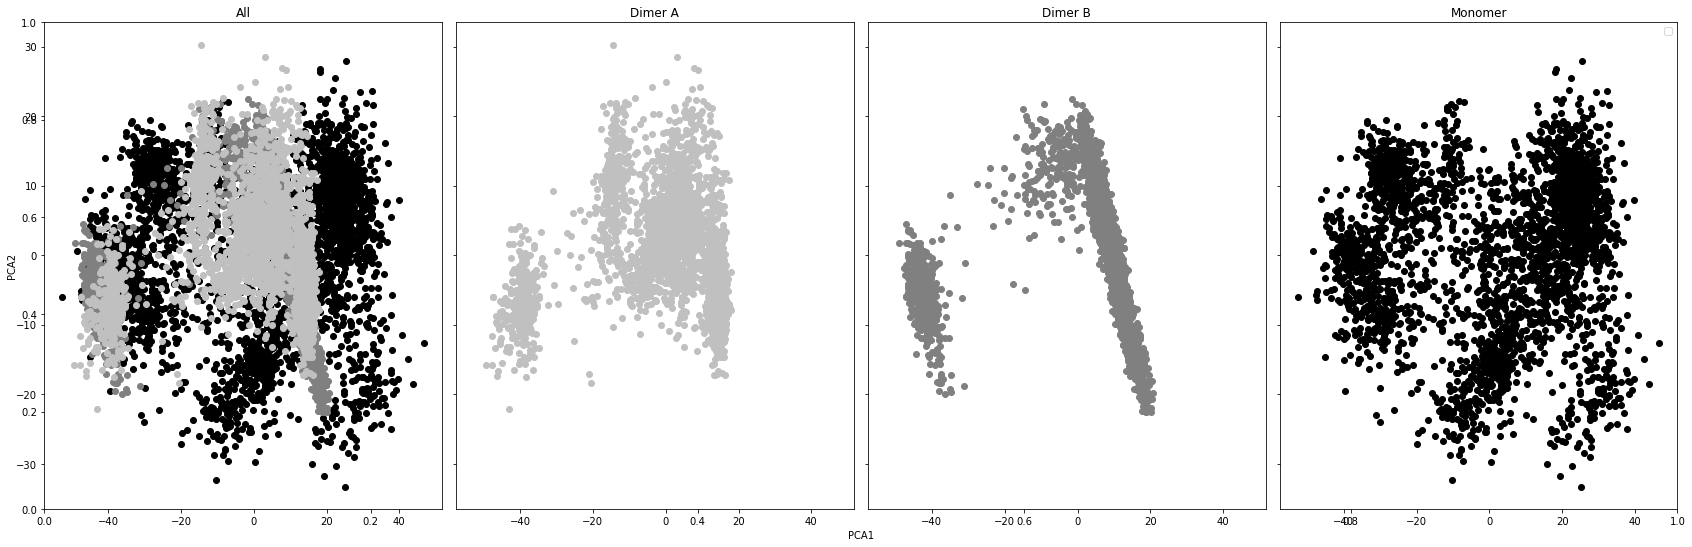

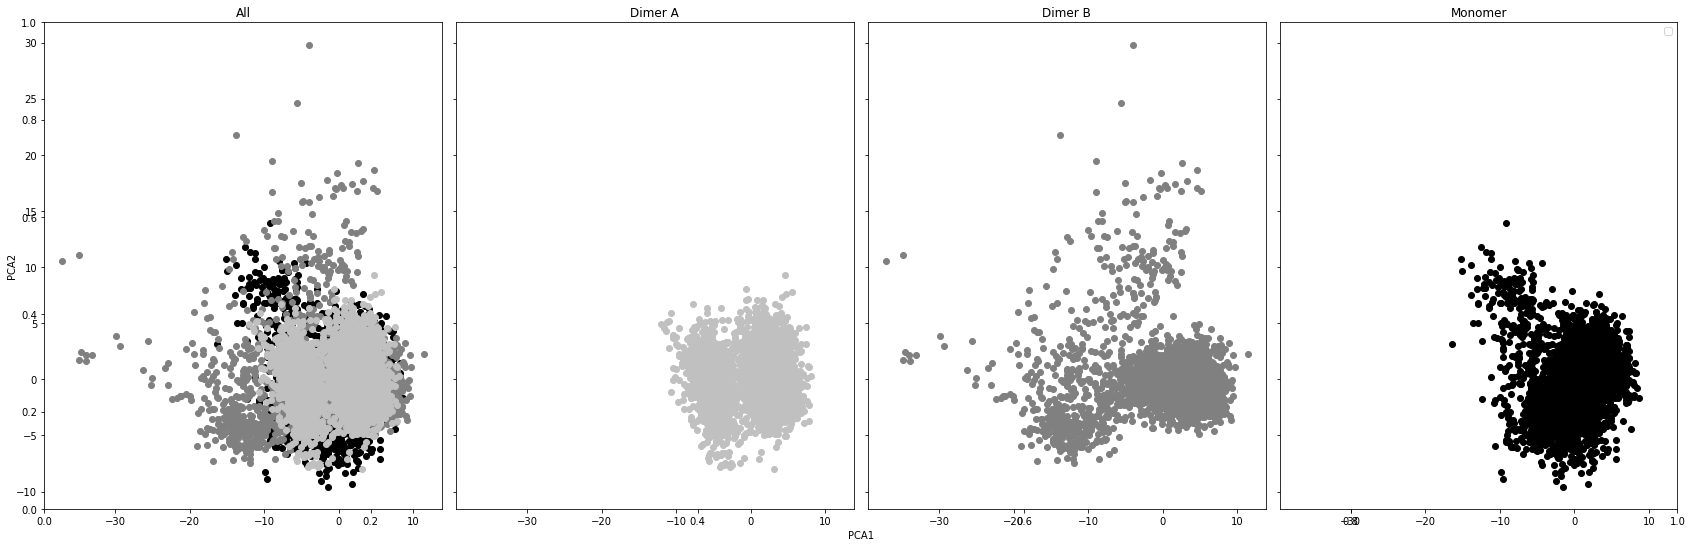

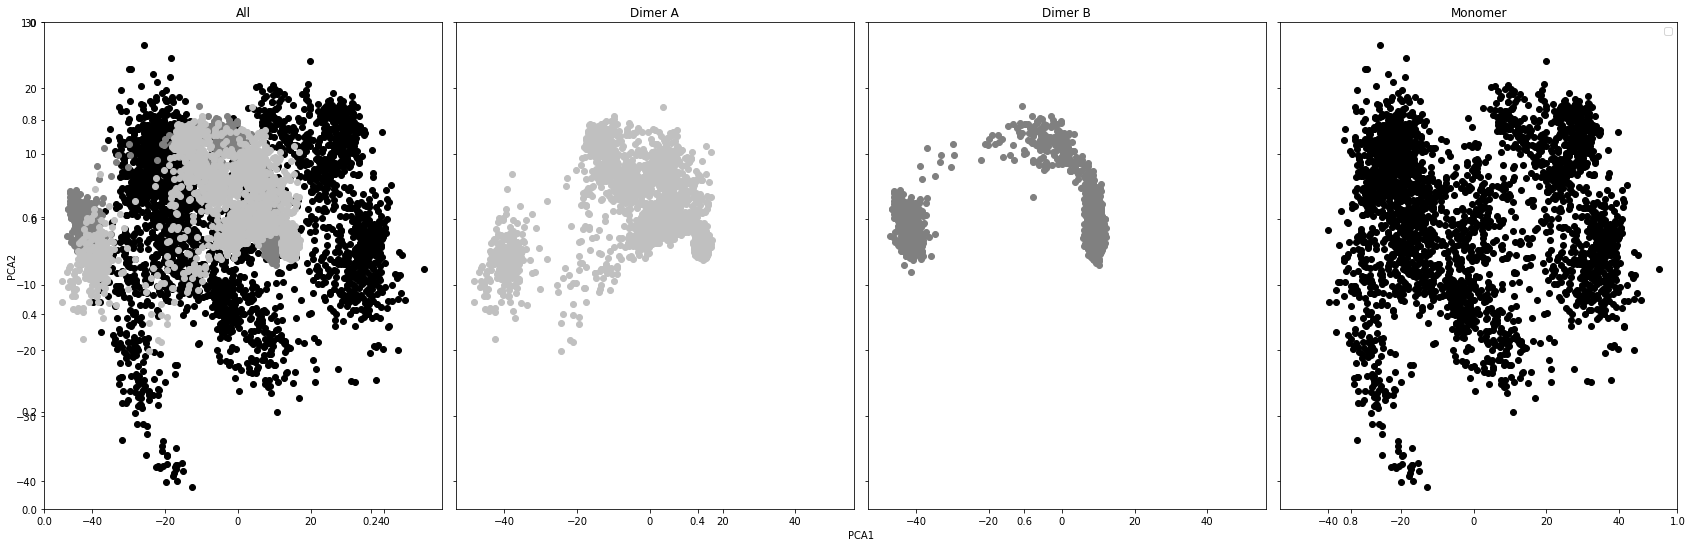

In [23]:
plot_pca(ens_monomer_pca,ens_asym_a_pca,ens_asym_b_pca,'protomer')
plot_pca(ens_monomer_pca,ens_asym_a_pca,ens_asym_b_pca,'domain1')
plot_pca(ens_monomer_pca,ens_asym_a_pca,ens_asym_b_pca,'domain2')
plot_pca(ens_monomer_pca,ens_asym_a_pca,ens_asym_b_pca,'domain3')
plot_pca(ens_monomer_pca,ens_asym_a_pca,ens_asym_b_pca,'idl')
plot_pca(ens_monomer_pca,ens_asym_a_pca,ens_asym_b_pca,'interface_ss')

### Ens (Fully Bound)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


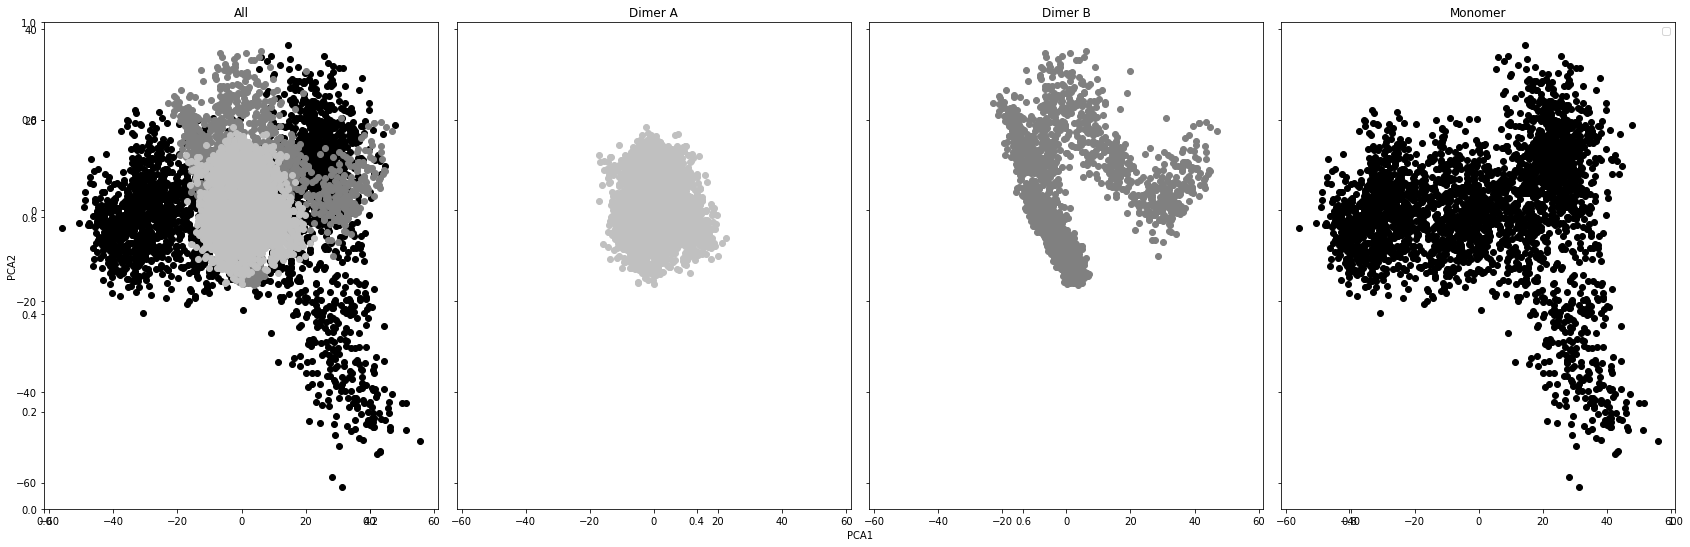

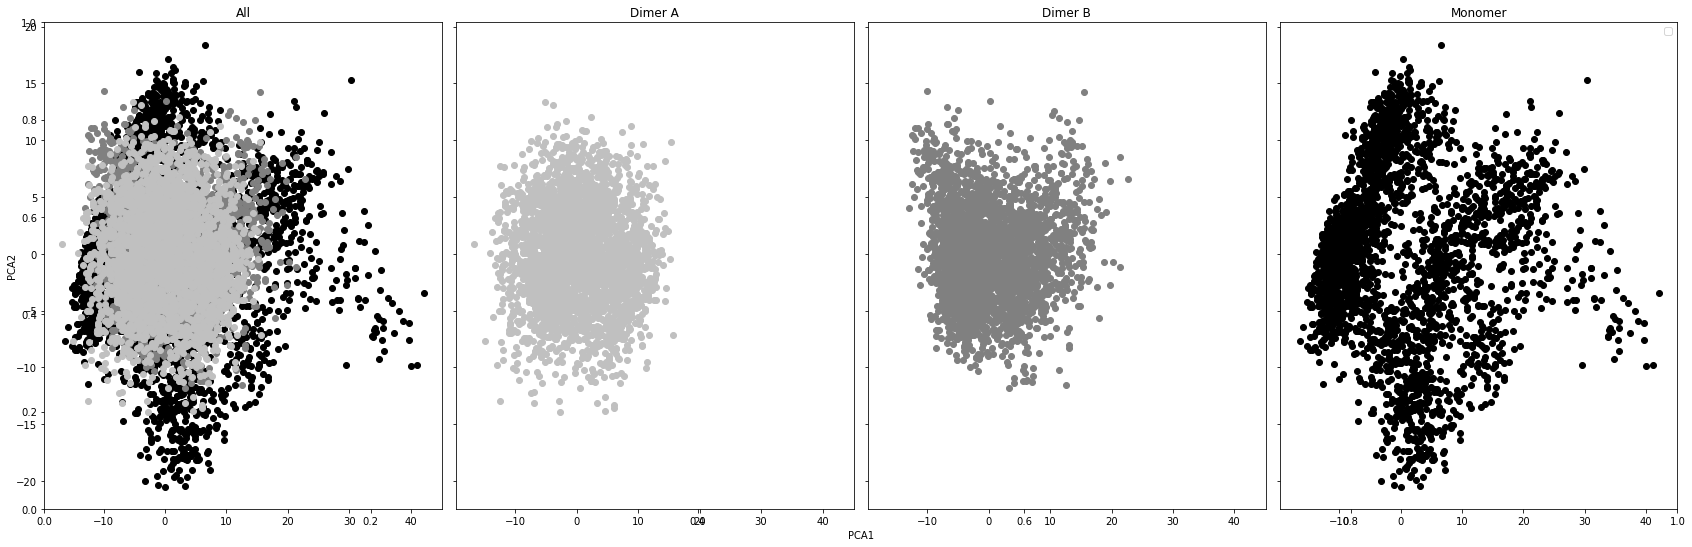

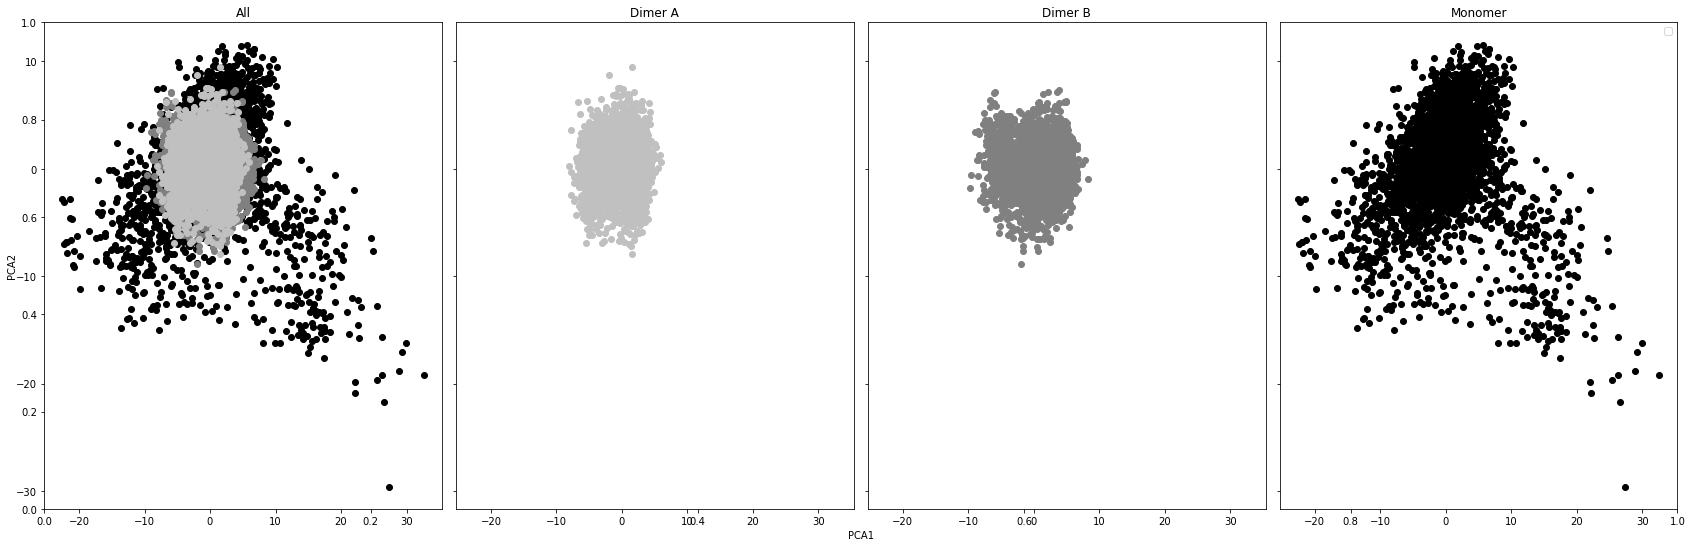

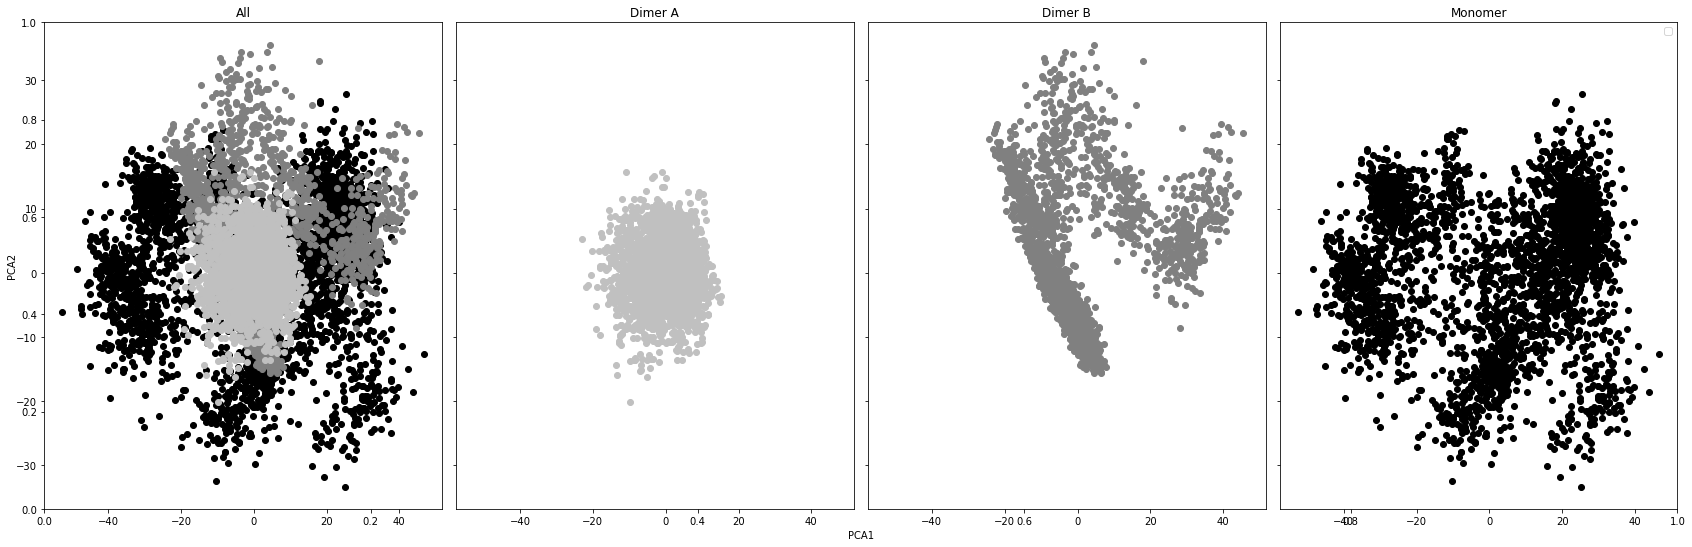

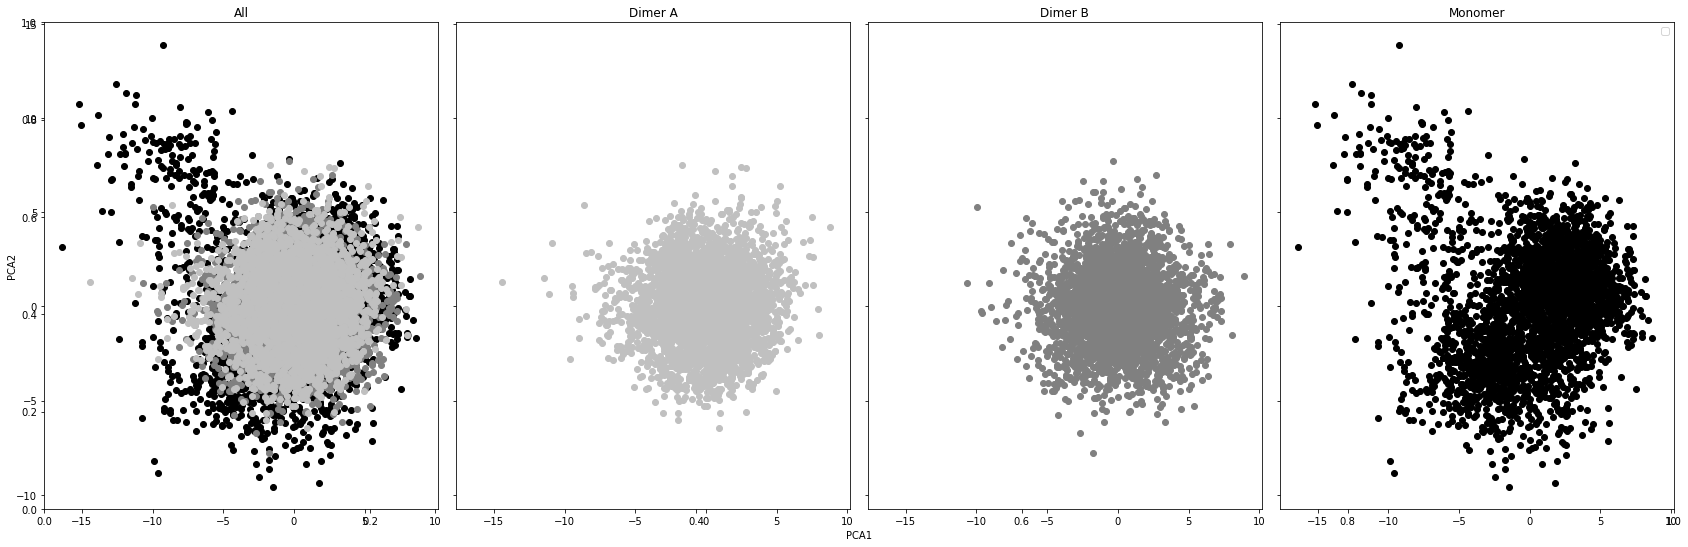

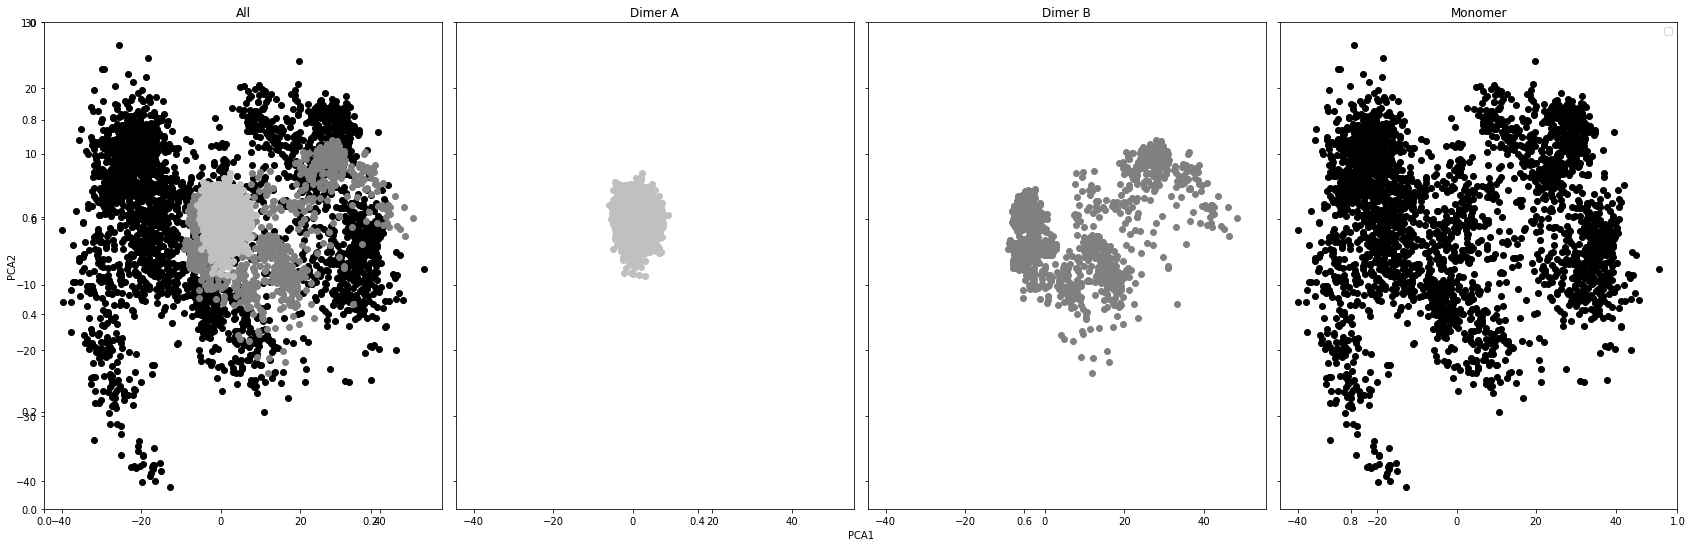

In [24]:
plot_pca(ens_monomer_pca,ens_dimer_a_pca,ens_dimer_b_pca,'protomer')
plot_pca(ens_monomer_pca,ens_dimer_a_pca,ens_dimer_b_pca,'domain1')
plot_pca(ens_monomer_pca,ens_dimer_a_pca,ens_dimer_b_pca,'domain2')
plot_pca(ens_monomer_pca,ens_dimer_a_pca,ens_dimer_b_pca,'domain3')
plot_pca(ens_monomer_pca,ens_dimer_a_pca,ens_dimer_b_pca,'idl')
plot_pca(ens_monomer_pca,ens_dimer_a_pca,ens_dimer_b_pca,'interface_ss')

## Protomer PCA

### Fully Bound Dimers

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


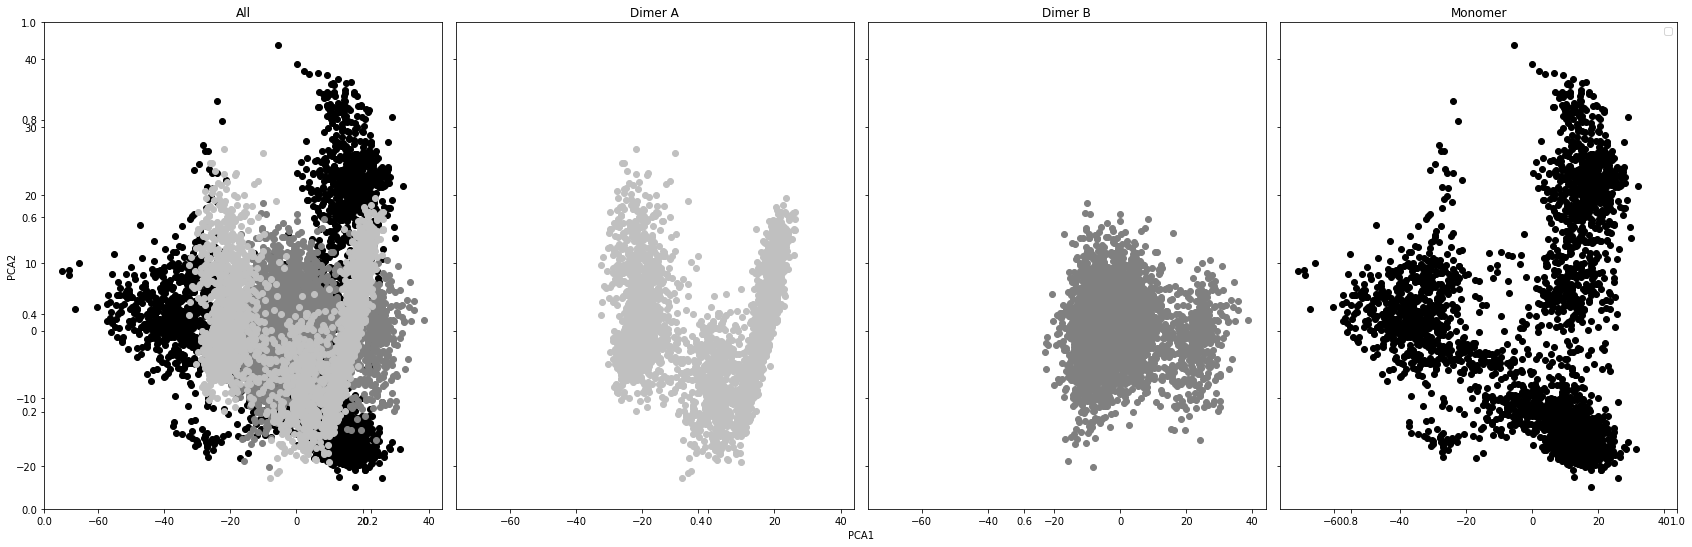

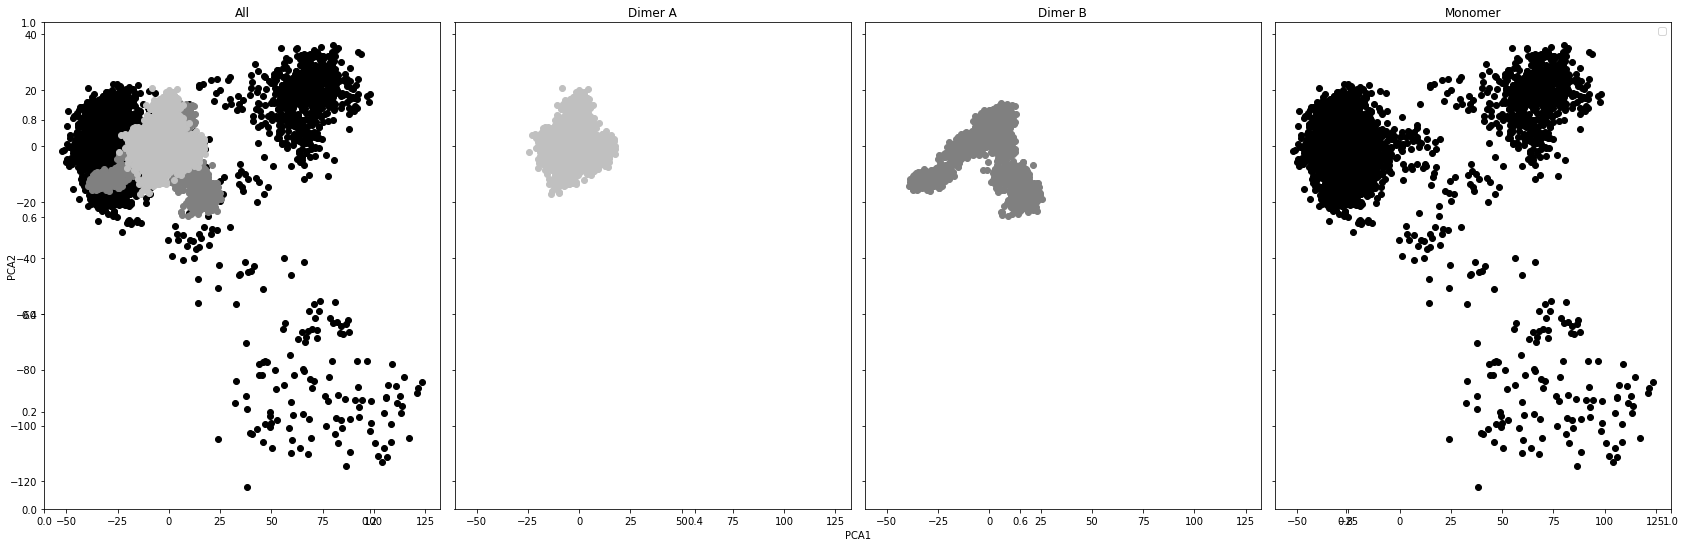

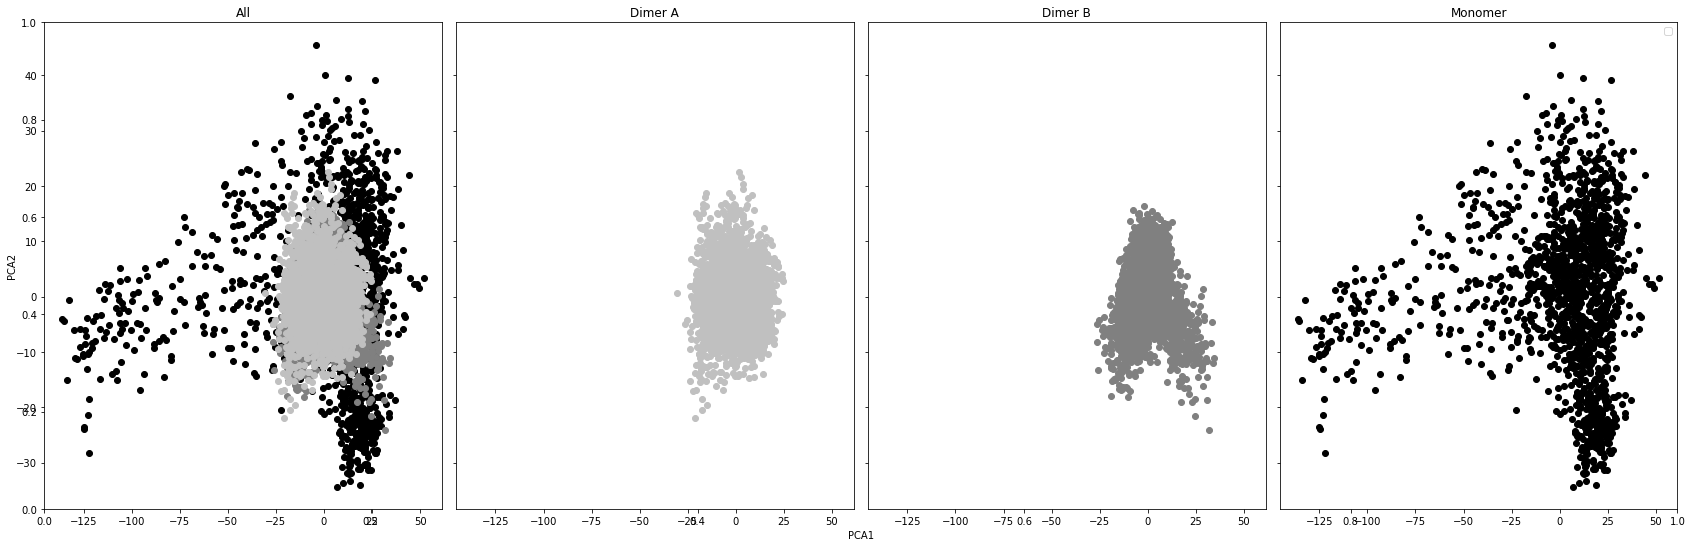

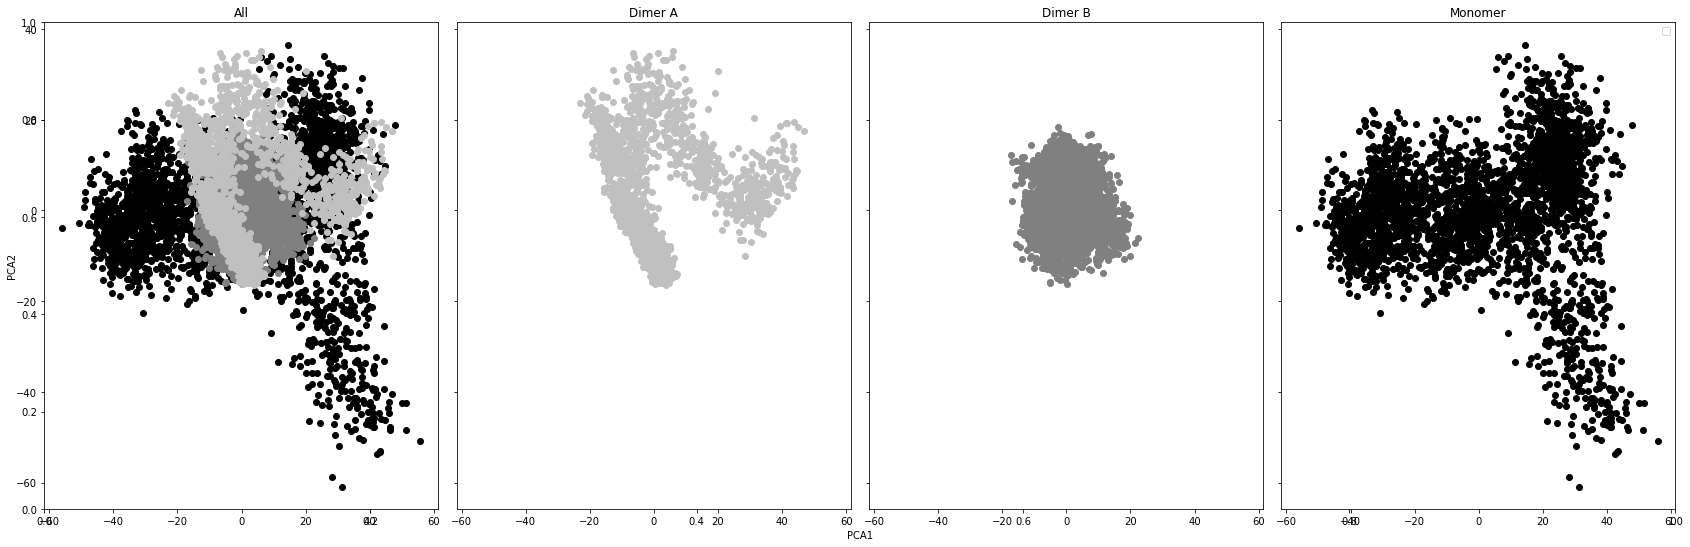

In [30]:
plot_pca(apo_monomer_pca,apo_dimer_a_pca,apo_dimer_b_pca,'protomer')
plot_pca(nat_monomer_pca,nat_dimer_a_pca,nat_dimer_b_pca,'protomer')
plot_pca(nirm_monomer_pca,nirm_dimer_b_pca,nirm_dimer_a_pca,'protomer')
plot_pca(ens_monomer_pca,ens_dimer_b_pca,ens_dimer_a_pca,'protomer')

### Interface SS PCA

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


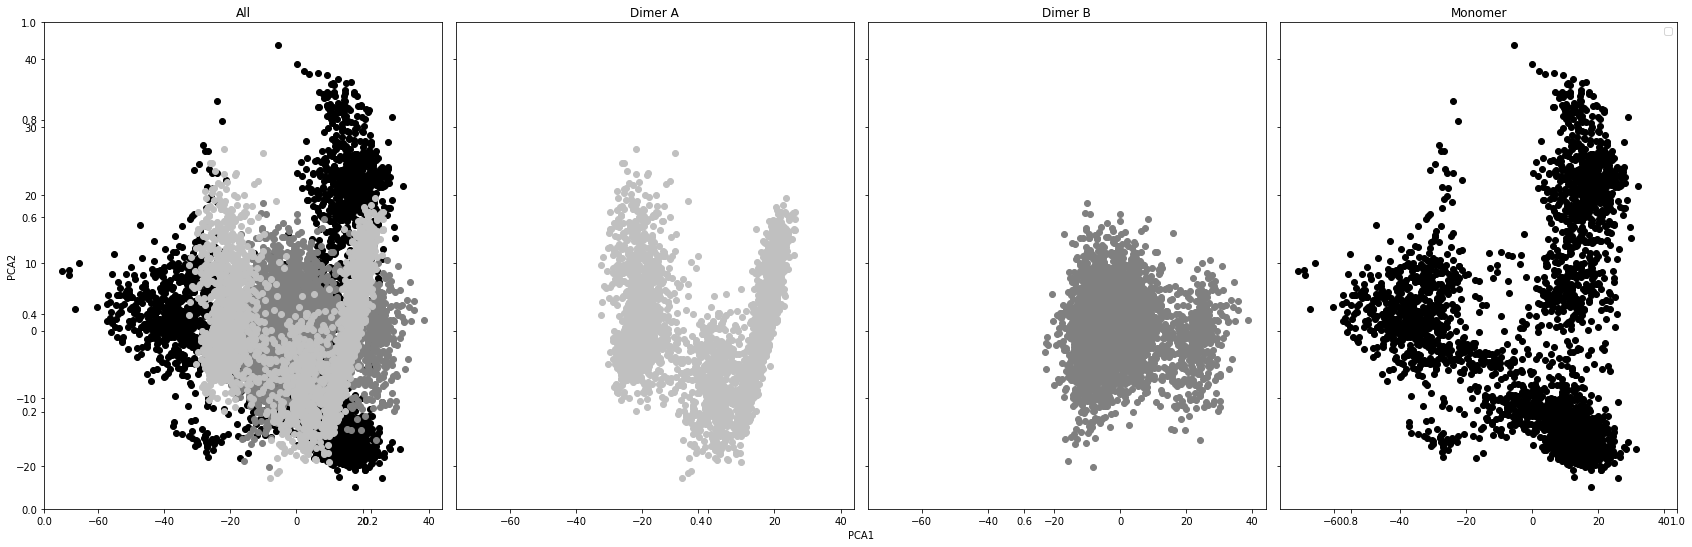

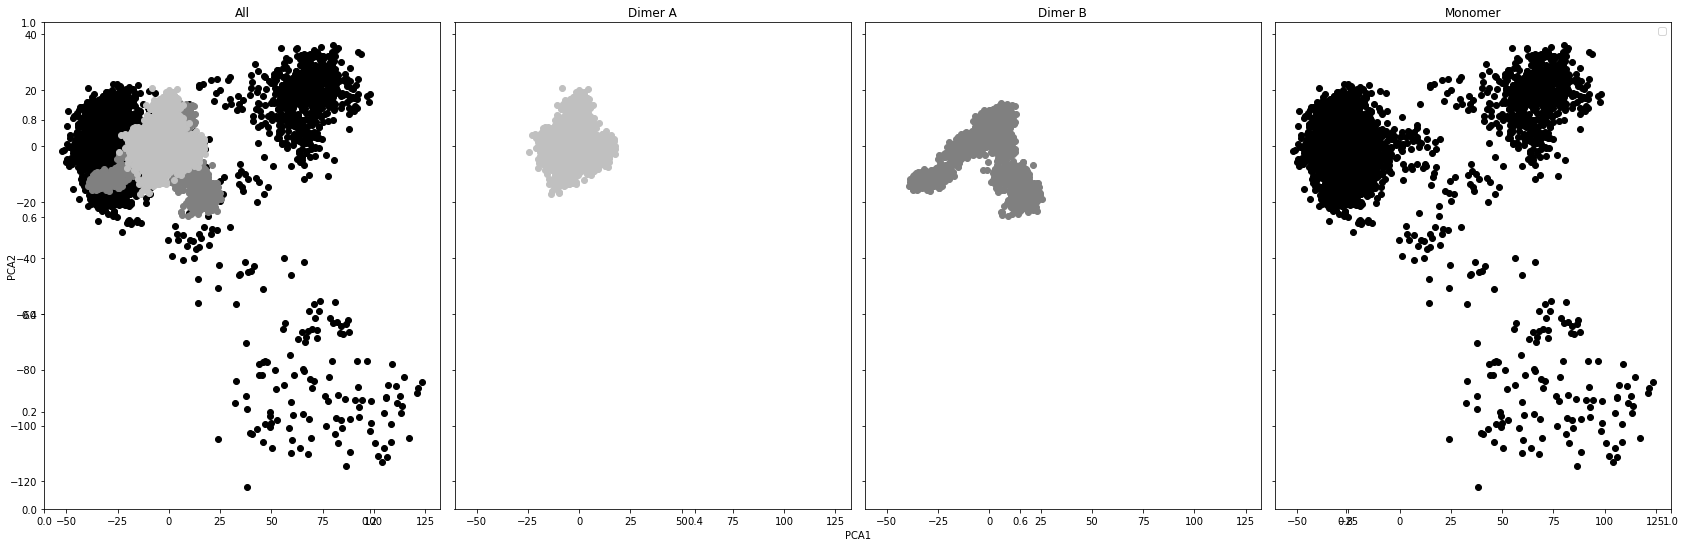

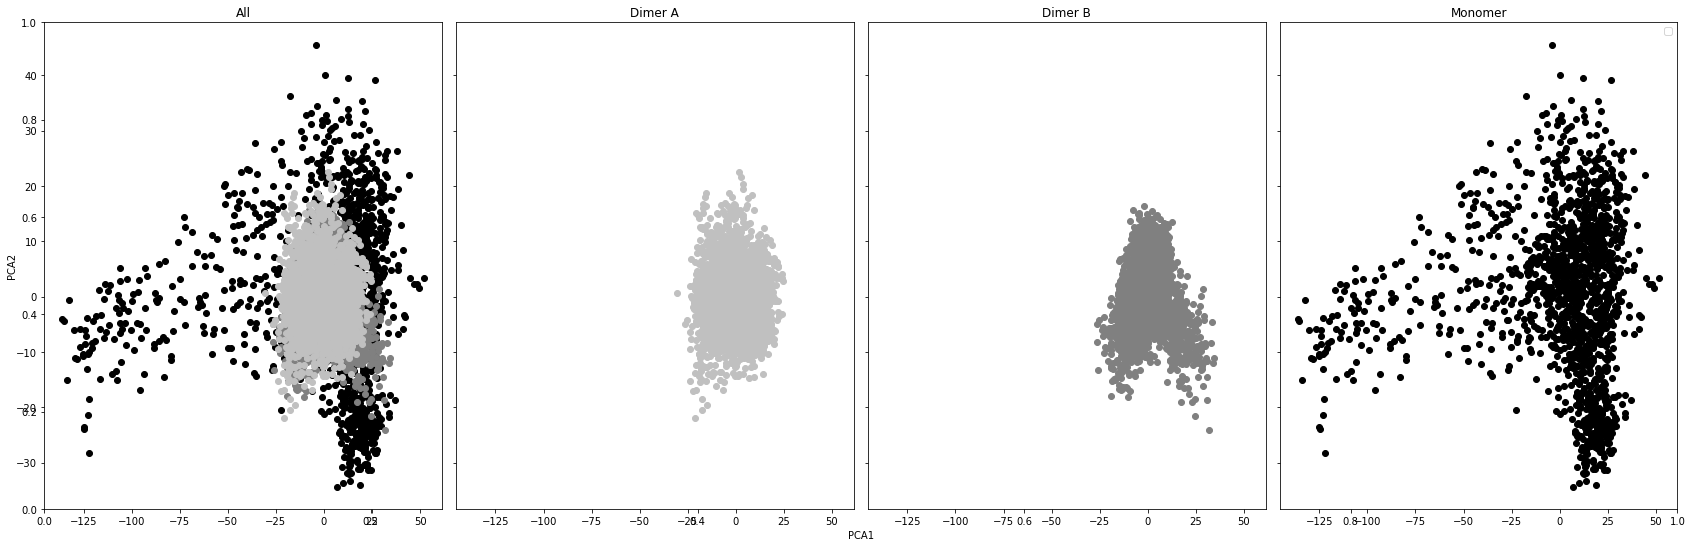

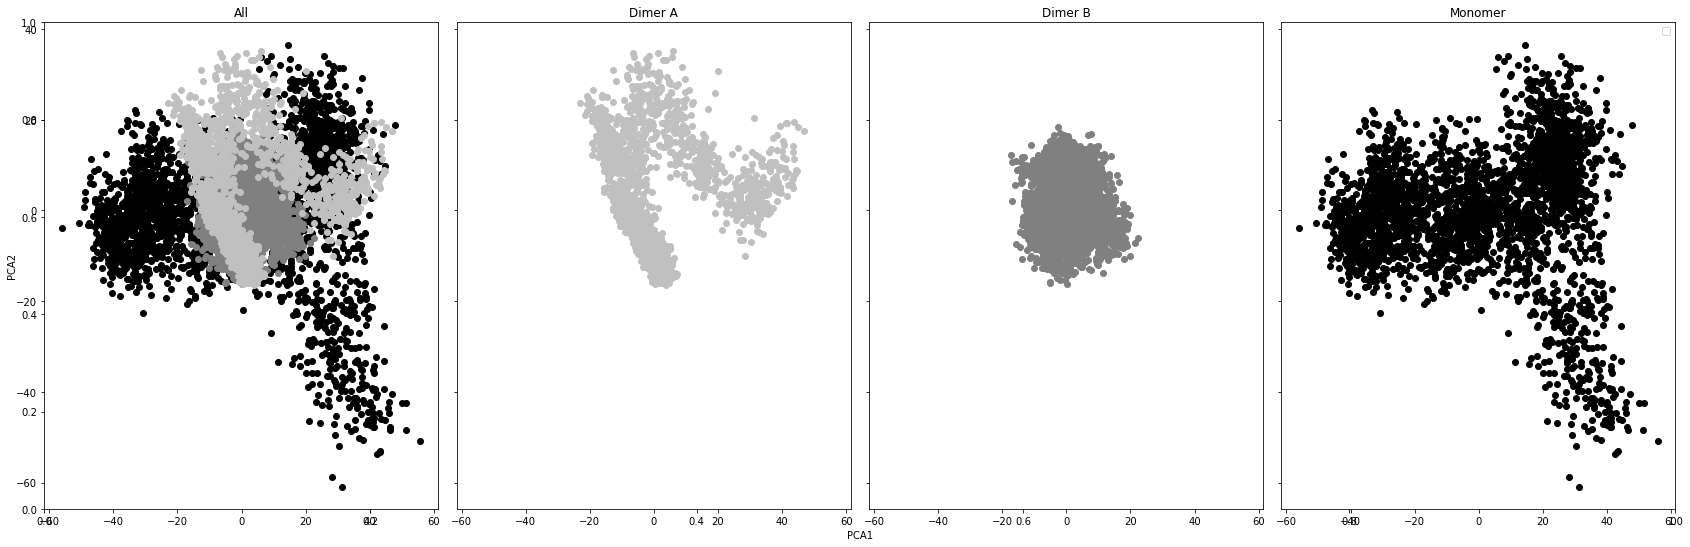

In [31]:
plot_pca(apo_monomer_pca,apo_dimer_a_pca,apo_dimer_b_pca,'protomer')
plot_pca(nat_monomer_pca,nat_dimer_a_pca,nat_dimer_b_pca,'protomer')
plot_pca(nirm_monomer_pca,nirm_dimer_b_pca,nirm_dimer_a_pca,'protomer')
plot_pca(ens_monomer_pca,ens_dimer_b_pca,ens_dimer_a_pca,'protomer')

## Plot all fully bound dimers into one PCA colored by volume distribution
### Apo: dark blue, blue, cyan
### Nat: dark orange, orange, gold
### Nirm: dark green, green, lime green
### Ens: dark red, red, crimson

In [55]:
sel = 'domain3'
sel_dict = {'protomer':'Full Protomer',
            'domain1':'Domain I',
           'domain2':'Domain II',
           'domain3':'Domain III',
           'idl':'Interdomain Loop',
           'interface_ss':'Interface SS',
           'nterm':'N-Terminus',
           'cterm':'C-Terminus'}

#APO
am_sel = apo_monomer_pca[sel]
ad_a_sel = apo_dimer_a_pca[sel]
ad_b_sel = apo_dimer_b_pca[sel]

#PEPTIDE
pm_sel = nat_monomer_pca[sel]

pd_a_sel = nat_dimer_a_pca[sel]
pd_b_sel = nat_dimer_b_pca[sel]

pa_a_sel = nat_asym_a_pca[sel]
pa_b_sel = nat_asym_b_pca[sel]

#NIRM
nm_sel = nirm_monomer_pca[sel]

nd_a_sel = nirm_dimer_a_pca[sel]
nd_b_sel = nirm_dimer_b_pca[sel]

na_a_sel = nirm_asym_a_pca[sel]
na_b_sel = nirm_asym_b_pca[sel]

#ENS
em_sel = ens_monomer_pca[sel]

ed_a_sel = ens_dimer_a_pca[sel]
ed_b_sel = ens_dimer_b_pca[sel]

ea_a_sel = ens_asym_a_pca[sel]
ea_b_sel = ens_asym_b_pca[sel]

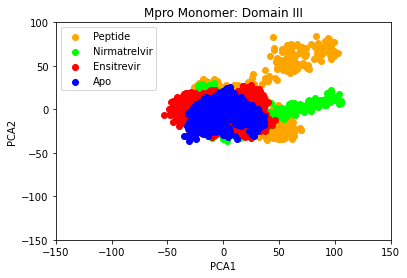

In [56]:
plt.scatter(pm_sel[:,0],pm_sel[:,1],color='orange',label='Peptide')
#plt.scatter(pd_a_sel[:,0],pd_a_sel[:,1],color='darkorange',label='Nat dimer A')
#plt.scatter(pd_b_sel[:,0],pd_b_sel[:,1],color='orange',label='Nat dimer B')

plt.scatter(nm_sel[:,0],nm_sel[:,1],color='lime',label='Nirmatrelvir')
#plt.scatter(nd_a_sel[:,0],nd_a_sel[:,1],color='limegreen',label='Nat dimer A')
#plt.scatter(nd_b_sel[:,0],nd_b_sel[:,1],color='lime',label='Nat dimer B')

plt.scatter(em_sel[:,0],em_sel[:,1],color='red',label='Ensitrevir')
#plt.scatter(ed_a_sel[:,0],ed_a_sel[:,1],color='red',label='Nat dimer A')
#plt.scatter(ed_b_sel[:,0],ed_b_sel[:,1],color='salmon',label='Nat dimer B')

plt.scatter(am_sel[:,0],am_sel[:,1],color='blue',label='Apo')
#plt.scatter(ad_a_sel[:,0],ad_a_sel[:,1],color='blue',label='Apo dimer A')
#plt.scatter(ad_b_sel[:,0],ad_b_sel[:,1],color='deepskyblue',label='Apo dimer B')

plt.xlabel('PCA1')
plt.xlim(-150,150)

plt.ylabel('PCA2')
plt.ylim(-150,100)

plt.legend()
plt.title('Mpro Monomer: ' + sel_dict[sel])

plt.savefig('/Users/javingfun/Downloads/PCA_nterm_monomer.png', dpi=300)

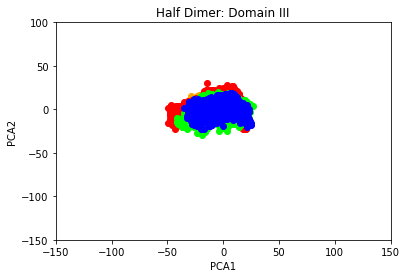

In [53]:
#plt.scatter(pm_sel[:,0],pm_sel[:,1],color='chocolate',label='Nat monomer')
plt.scatter(pa_a_sel[:,0],pa_a_sel[:,1],color='orange',label='Peptide')
plt.scatter(pa_b_sel[:,0],pa_b_sel[:,1],color='orange')

#plt.scatter(em_sel[:,0],em_sel[:,1],color='firebrick',label='Ens monomer')
plt.scatter(ea_a_sel[:,0],ea_a_sel[:,1],color='red',label='Ensitrevir')
plt.scatter(ea_b_sel[:,0],ea_b_sel[:,1],color='red')

#plt.scatter(nm_sel[:,0],nm_sel[:,1],color='green',label='Nirm monomer')
plt.scatter(na_a_sel[:,0],na_a_sel[:,1],color='lime',label='Nirmatrelvir')
plt.scatter(na_b_sel[:,0],na_b_sel[:,1],color='lime')

#plt.scatter(am_sel[:,0],am_sel[:,1],color='darkblue',label='Apo monomer')
plt.scatter(ad_a_sel[:,0],ad_a_sel[:,1],color='blue',label='Apo')
plt.scatter(ad_b_sel[:,0],ad_b_sel[:,1],color='blue')

plt.xlabel('PCA1')
plt.xlim(-150,150)

plt.ylabel('PCA2')
plt.ylim(-150,100)

#plt.legend()
plt.title('Half Dimer: ' + sel_dict[sel])

plt.savefig('/Users/javingfun/Downloads/PCA_domain3_asym.png', dpi=300)

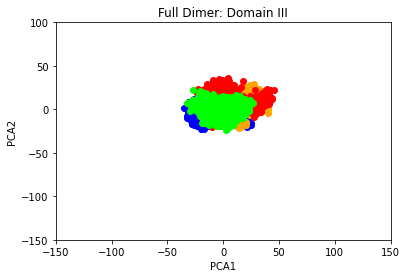

In [54]:
#plt.scatter(am_sel[:,0],am_sel[:,1],color='darkblue',label='Apo monomer')
plt.scatter(ad_a_sel[:,0],ad_a_sel[:,1],color='blue',label='Apo')
plt.scatter(ad_b_sel[:,0],ad_b_sel[:,1],color='blue')

#plt.scatter(pm_sel[:,0],pm_sel[:,1],color='chocolate',label='Nat monomer')
plt.scatter(pd_a_sel[:,0],pd_a_sel[:,1],color='orange',label='Peptide')
plt.scatter(pd_b_sel[:,0],pd_b_sel[:,1],color='orange')

#plt.scatter(em_sel[:,0],em_sel[:,1],color='firebrick',label='Ens monomer')
plt.scatter(ed_a_sel[:,0],ed_a_sel[:,1],color='red',label='Ensitrevir')
plt.scatter(ed_b_sel[:,0],ed_b_sel[:,1],color='red')

#plt.scatter(nm_sel[:,0],nm_sel[:,1],color='green',label='Nirm monomer')
plt.scatter(nd_a_sel[:,0],nd_a_sel[:,1],color='lime',label='Nirmatrelvir')
plt.scatter(nd_b_sel[:,0],nd_b_sel[:,1],color='lime')

plt.xlabel('PCA1')
plt.xlim(-150,150)

plt.ylabel('PCA2')
plt.ylim(-150,100)

#plt.legend()
plt.title('Full Dimer: ' + sel_dict[sel])

plt.savefig('/Users/javingfun/Downloads/PCA_domain3_dimer.png', dpi=300)

In [28]:
x = [45,49,189, 192]
for num in x:
    print(num+306)

351
355
495
498
